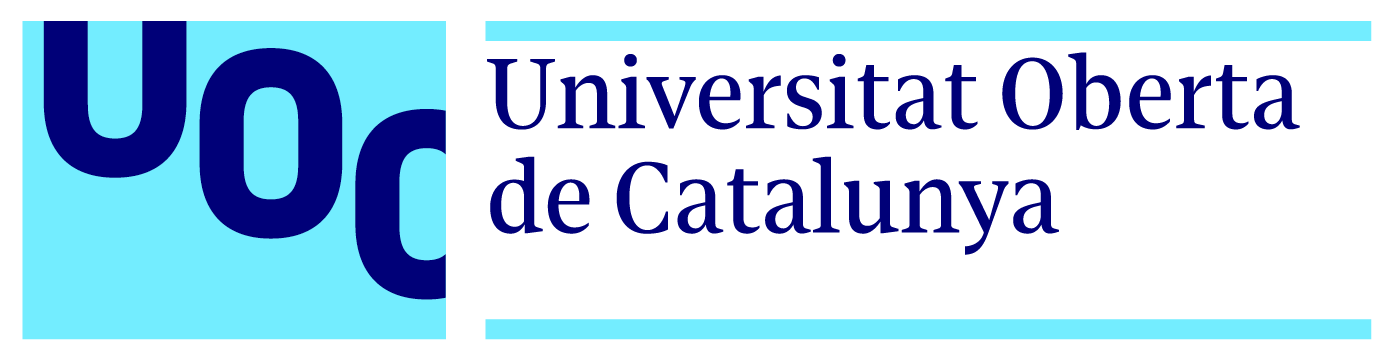

# TFM: 03_ Modelado Filtrado

Este es el Notebook número 3 de la entrega de la PEC3. En este notebook se explica todos los pasos realizados para realizar el proceso de modelado de la solución con sus correspondientes soluciones con la particularidad del filtrado de ventas a 0 que suspondrá el cambio de algunas conclusiones con el modelo anterios


### Indice

* 1.Carga de Datos
* 2. Exploración de los datos
* 3. Generación de variables
* 4. Establecer periodo de entrenamiento y test
 * Estudio elimnando periodo Covid
 * Definición de periodos
* 5. Feature Engineering Final
* 6. Escalado de los datos
* 7. Creación de modelo de solución
* 8. Estructura de la solución
* 9. Indicadores de precisión
* 10. Selección de modelos
 * XGBoost
 * Stacking XGBoost
 * Stacking 2 LightGBM, XGB, CatBoost, MLPRegressor.
 * LSTM básica.
* 10. Conclusiones
  * Conclusiones  Generales.
  * Mejores Modelos
  * Comparación de todos los modelos con Previsión de empresa
* 11. Cálculo de Costes
 * Conclusión del modelo vs Previsión de empresa
 * Conclusión de Costes
 * Redución de Costes


### Salidas:

Debido a la complejidad de la solución y el tiempo de entrenamiento se crean ficheros de salida para  ver las soluciones sin ejecutar el modelo:




- Metricas_pred: Fichero de métricas que contiene todas las métricas de todos los productos por modelo. Estas métricas son generadas con el conjunto test que son los datos que el modelo no a usado para entrenar ni validar.
- prediciones_fin: Fichero que contiene todas las prediciones por modelo y producto de los diferentes modelo con el conjunto de test.

- Metricas_val: Fichero de métricas que contiene lás metricas de los productos por modelo. Estás metricas son generadas con el conjunto de validación que son los datos que usa el modelo para extraer la mejor solución.

- prediciones_val: Fichero que contiene las prediciones realizadas con el conjunto de validación por los diferentes modelos.
- costes:  Fichero que contiene los costes diarios por producto del modelo que predice mejor la demanda y los costes diaros de la empresa tradicional

-  Gráfico dinámico donde se expone la solución del Coste del modelo vs Coste de la predición tradicional( 11 Calculo de Costes)

### Librerias

In [ ]:
import pandas as pd
from datetime import timedelta 
import numpy as np
ruta ="/content/gdrive/MyDrive/TFM/3/"
#ruta = 'C:/Users/alfonso/Desktop/TFM/'
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.metrics import BinaryAccuracy,AUC
import seaborn as sns


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1 Carga de los datos

In [ ]:
df=pd.read_csv(ruta+"MODELAR_FINAL.csv")


# 2 Exploración de los datos

In [ ]:
df.head()

,producto,fecha,promocion,festivo,precio,pre_promocion,Media_W4,Media_W2,Mediana_7D,MAX_2M,UpperBand_weekly,UpperBand_monthly,udsVenta,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,w_1,w_2,w_3,w_4,rsi_cat_1,rsi_cat_2,rsi_cat_3,categorias,udsPrevisionEmpresa
0,1,2015-06-29,0.0,0.0,3.8232,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3266.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,18,NaN
1,1,2015-06-30,0.0,0.0,3.8232,0.0,NaN,3732.5,NaN,NaN,NaN,NaN,4199.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,18,NaN
2,1,2015-07-01,0.0,0.0,3.8232,0.0,NaN,9331.0,NaN,NaN,NaN,NaN,14463.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,18,NaN
3,1,2015-07-02,0.0,0.0,3.8232,0.0,NaN,9331.0,NaN,NaN,NaN,NaN,4199.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,18,NaN
4,1,2015-07-03,0.0,0.0,3.8232,0.0,NaN,6065.5,NaN,NaN,NaN,NaN,7932.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,18,NaN


In [ ]:
## Se eliminan todas las variables relacionadas con la variable ventas

In [ ]:
df=df.drop(['Media_W4',"Media_W2",'Mediana_7D',"MAX_2M","UpperBand_weekly","UpperBand_monthly","rsi_cat_1","rsi_cat_2","rsi_cat_3"], axis = 1)

In [ ]:
df.head()

,producto,fecha,promocion,festivo,precio,pre_promocion,udsVenta,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,w_1,w_2,w_3,w_4,categorias,udsPrevisionEmpresa
0,1,2015-06-29,0.0,0.0,3.8232,0.0,3266.0,0,1,0,0,0,0,0,0,0,0,1,18,NaN
1,1,2015-06-30,0.0,0.0,3.8232,0.0,4199.0,0,0,0,0,0,1,0,0,0,0,1,18,NaN
2,1,2015-07-01,0.0,0.0,3.8232,0.0,14463.0,0,0,0,0,0,0,1,1,0,0,0,18,NaN
3,1,2015-07-02,0.0,0.0,3.8232,0.0,4199.0,0,0,0,0,1,0,0,1,0,0,0,18,NaN
4,1,2015-07-03,0.0,0.0,3.8232,0.0,7932.0,1,0,0,0,0,0,0,1,0,0,0,18,NaN


In [ ]:
df[["fecha","producto"]].duplicated().sum()

0

In [ ]:
df[["fecha","producto"]].isna().sum()

fecha       0
producto    0
dtype: int64

In [ ]:
df.shape

(139823, 20)

In [ ]:
## Se filtra por unidades vendidas distintas de cero

In [ ]:
df=df.loc[df["udsVenta"]!=0]

In [ ]:
df=df.drop(['weekday_Sunday'],axis=1)

# 3 Generación de variables

Dado que se reduce el conjunto de datos, los valores generados en base a las unidades vendidas también cambian, por ello se vuelven a calcular las variables asociadas a la demanda

#### Generación de medidas moviles

Se calcula la medidas móvil para homogenizar las tendencias durante un periodo de tiempo además ayuda al modelo a entender la tendencia de la demanda en un periodo en particular

Se calculan por producto:
* *Media_W4* La media de los últimos 4 días de la semana correspondientes. Por ejemplo, la media de los últimos 4 Lunes.
* *Media_W2* Meda de los últimos 2 días de la semana. Por ejemplo, la media de ventas de los últimos 2 Lunes.

* *Mediana_7D* Mediana de los últimos 7 días.



In [ ]:
 df["fecha"]=pd.to_datetime(df['fecha'])

In [ ]:
df['day_of_week'] = df['fecha'].dt.dayofweek


In [ ]:
Productos=np.unique(df["producto"])
dias=np.unique(df["day_of_week"])

In [ ]:
for i in  Productos:
  for j in  dias:
   df.loc[(df["producto"]==i)&(df["day_of_week"]== j),'Media_W4']=df.loc[(df["producto"]==i)&(df["day_of_week"]== j),"udsVenta"].rolling(window=4).mean()

In [ ]:
for i in  Productos:
  for j in  dias:
       df.loc[(df["producto"]==i)&(df["day_of_week"]== j),'Media_W2']=df.loc[(df["producto"]==i)&(df["day_of_week"]== j),"udsVenta"].rolling(window=2).mean()

In [ ]:
for i in  Productos:
  for j in  dias:
       df.loc[(df["producto"]==i),'Mediana_7D']=df.loc[(df["producto"]==i),"udsVenta"].rolling(window=7).median()

In [ ]:
Cruce_df4=df

### Índice de fuerza relativa (RSI)

El Índice de Fuerza Relativa (RSI) calcula una relación entre los recientes movimientos de ventas al alza y el movimiento de ventas  absoluto. Esto sirve para medir tanto la velocidad en los cambios en la demanda como también los posibles niveles de sobre demanda o al contrario.  

 En primer lugar, se obtiene la ganancia o pérdida promedio, que mide la suba o baja promedio de ventas  durante período determinado. En este caso 2 semanas.

 Con estas dos variables se calcula la fuerza promedia que es la división de estas variables y posteriormente se normaliza para  RSI se calcula como RSI = 100  100 / (1+RS) que fluctua de 0 100. Un valor de RSI cero significa que los precios se movieron a la baja en los 14 periodos y por tanto seguirá llendo a la baja. 

El RSI se interpreta como un indicador de sobrecompra/sobreventa cuando el valor es superior a 70/inferior a 30. En este caso se interpretará como oscilación hacia el aumento de compras si es mayor de 70 y cuando el indicador sea menor que 30 la oscilación de la demanda caerá a la baja

Indicar que como la estacionalidad es semanal el indicador rondará el valor 50 debido a las caidas de demanda y las tendencias son semanales

In [ ]:
for k in  Productos:
    df= Cruce_df4.loc[(Cruce_df4["producto"]==k)][["udsVenta"]]
    df['change'] = df['udsVenta'].diff(1) # Calculate change
    # calculate gain / loss from every change
    df['gain'] = np.select([df['change']>0, df['change'].isna()], 
                          [df['change'], np.nan], 
                          default=0) 
    df['loss'] = np.select([df['change']<0, df['change'].isna()], 
                          [-df['change'], np.nan], 
                          default=0)

    # create avg_gain /  avg_loss columns with all nan
    df['avg_gain'] = np.nan 
    df['avg_loss'] = np.nan

    n = 14 # what is the window

    # keep first occurrence of rolling mean
    df['avg_gain'][n] = df['gain'].rolling(window=n).mean().dropna().iloc[0] 
    df['avg_loss'][n] = df['loss'].rolling(window=n).mean().dropna().iloc[0]
    # Alternatively
    df['avg_gain'][n] = df.loc[:n, 'gain'].mean()
    df['avg_loss'][n] = df.loc[:n, 'loss'].mean()

    # This is not a pandas way, looping through the pandas series, but it does what you need
    for i in range(n+1, df.shape[0]):
        df['avg_gain'].iloc[i] = (df['avg_gain'].iloc[i-1] * (n - 1) + df['gain'].iloc[i]) / n
        df['avg_loss'].iloc[i] = (df['avg_loss'].iloc[i-1] * (n - 1) + df['loss'].iloc[i]) / n

    # calculate rs and rsi
    df['rs'] = df['avg_gain'] / df['avg_loss']
    df['rsi'] = 100 - (100 / (1 + df['rs'] ))



    Cruce_df4.loc[(Cruce_df4["producto"]==k),'rsi']=df[['rsi']].to_numpy() 
    Cruce_df4.loc[(Cruce_df4["producto"]==k),'avg_gain_14D']=df[['avg_gain']].to_numpy() 
    Cruce_df4.loc[(Cruce_df4["producto"]==k),'avg_loss_14D']=df[['avg_loss']].to_numpy() 

### Bandas de Bollinger


Bandas de Bollinger (BB) - Las bandas de Bollinger constan de tres líneas. La banda central es una media móvil simple del precio. Las bandas superior e inferior son desviaciones estándar F (generalmente 2) por encima y por debajo de la banda media. Las bandas se ensanchan y estrechan cuando la volatilidad del precio es mayor o menor, respectivamente.

 En este caso como la desviación es muy grande se crean 2 bandas superiores. Una linea semanal y una mensual

In [ ]:
multiplier = 2

In [ ]:
for k in  Productos:
    plot2= Cruce_df4.loc[(Cruce_df4["producto"]==k)][["udsVenta"]]
    plot2['UpperBand_weekly'] = plot2['udsVenta'].rolling(7).mean() + plot2['udsVenta'].rolling(7).std() * multiplier
    plot2['UpperBand_monthly'] = plot2['udsVenta'].rolling(28).mean()+ plot2['udsVenta'].rolling(28).std() * multiplier
    Cruce_df4.loc[(Cruce_df4["producto"]==k),'UpperBand_weekly']=plot2[['UpperBand_weekly']].to_numpy() 
    Cruce_df4.loc[(Cruce_df4["producto"]==k),'UpperBand_monthly']=plot2[['UpperBand_monthly']].to_numpy() 


## Feature Engineering Final

In [ ]:
Cruce_df4.columns

Index(['producto', 'fecha', 'promocion', 'festivo', 'precio', 'pre_promocion',
       'udsVenta', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'w_1',
       'w_2', 'w_3', 'w_4', 'categorias', 'udsPrevisionEmpresa', 'day_of_week',
       'Media_W4', 'Media_W2', 'Mediana_7D', 'rsi', 'avg_gain_14D',
       'avg_loss_14D', 'UpperBand_weekly', 'UpperBand_monthly'],
      dtype='object')

In [ ]:
Cruce_df4=Cruce_df4.drop(['day_of_week','avg_gain_14D',"avg_loss_14D"], axis = 1)

Se categoriza el indicador RSI

In [ ]:
bins = [0, 29.999, 69.999, 1000]
group_names = [1,2,3]
Cruce_df4['rsi_cat'] = pd.cut(Cruce_df4['rsi'], bins, labels=group_names)


Se crean las variables one-hot-encoding del indicador RSI

In [ ]:
final_df = pd.get_dummies(Cruce_df4, columns=["rsi_cat"])

In [ ]:
final_df = final_df.drop(['rsi'], axis = 1)

In [ ]:
final_df.tail()

,producto,fecha,promocion,festivo,precio,pre_promocion,udsVenta,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,w_1,w_2,w_3,w_4,categorias,udsPrevisionEmpresa,Media_W4,Media_W2,Mediana_7D,UpperBand_weekly,UpperBand_monthly,rsi_cat_1,rsi_cat_2,rsi_cat_3
139788,99,2021-02-17,0.0,0.0,0.0,0.0,680.0,0,0,0,0,0,1,0,0,1,0,19,3149.0,595.25,583.0,486.0,866.453054,924.010758,0,0,0
139815,99,2021-03-16,0.0,0.0,0.0,0.0,97.0,0,0,0,0,1,0,0,0,1,0,19,NaN,231.00,121.5,486.0,843.534341,861.896324,0,0,0
139816,99,2021-03-17,0.0,0.0,0.0,0.0,437.0,0,0,0,0,0,1,0,0,1,0,19,NaN,570.75,558.5,437.0,832.341688,857.588308,0,0,0
139818,99,2021-03-19,0.0,0.0,0.0,0.0,486.0,1,0,0,0,0,0,0,0,1,0,19,NaN,393.50,534.5,486.0,850.391484,839.544946,0,0,0
139822,99,2021-03-23,0.0,0.0,0.0,0.0,146.0,0,0,0,0,1,0,0,0,0,1,19,NaN,194.50,121.5,437.0,839.918479,837.878654,0,0,0


# 4 Establecer periodo de entrenamiento y Test

In [ ]:
df=final_df

Se estudia los posibles periodos de entramiento, validación y test

In [ ]:
Total_Ventas=df[["fecha","udsVenta"]]

In [ ]:
Total_prev=df[["fecha","udsPrevisionEmpresa"]]

In [ ]:
Total_Ventas_año=Total_Ventas.groupby('fecha').mean('udsVenta')

In [ ]:
Total_Ventas_año2=Total_Ventas.groupby('fecha').sum('udsVenta')

In [ ]:
df_ventas = Total_Ventas_año.loc[(Total_Ventas_año.index >'2015-09-01') & (Total_Ventas_año.index<'2021-03-31')]

In [ ]:
df_ventas2 = Total_Ventas_año2.loc[(Total_Ventas_año2.index >'2015-09-01') & (Total_Ventas_año2.index <'2021-01-31')]

In [ ]:
plot2=df_ventas
plot2["fecha"]=df_ventas.index

<Figure size 1440x720 with 0 Axes>

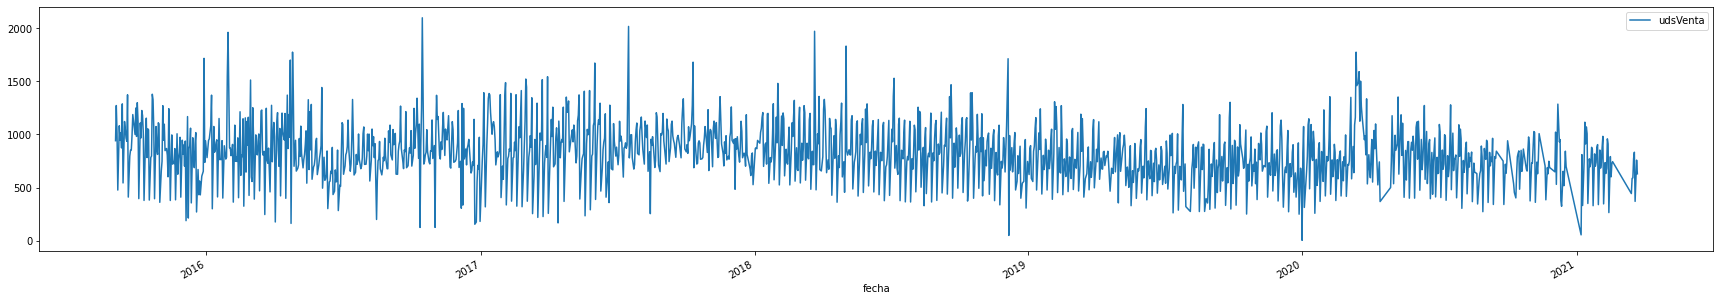

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
plot2.plot(x="fecha", y='udsVenta', figsize=(30, 5))
plt.show()

 El estallido de la pandemia del coronavirus y las medidas sanitarias encaminadas a su mitigación han dado lugar al escenario no común en el tiempo y por tanto será eliminado y no usado ni para entrenamiento ni test. Porque no tenemos historia de escenarios similares a la pandemia mundial

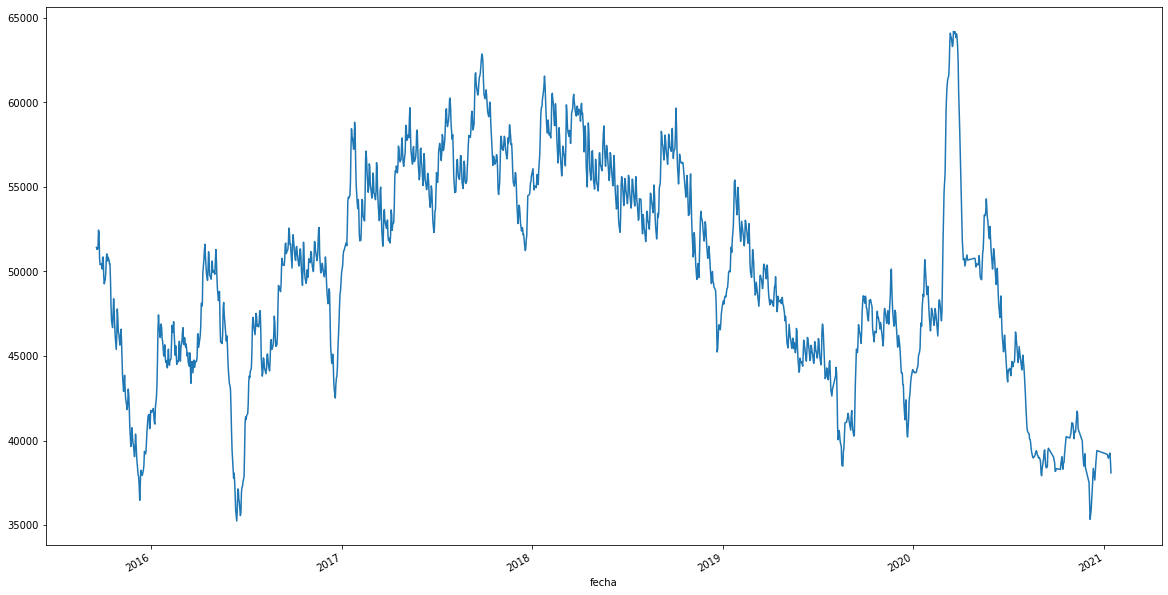

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (20,11)
res = seasonal_decompose(df_ventas2['udsVenta'],model='additive', freq=28)
res.trend.plot()
plt.show()


### Estudio Eliminando periodo Covid

Observamos periodos temporales similares. Seleccionamos periodos similares para validación y test.

Lo que se busca es que las prediciones finales del modelo no conozcan   los  datos dando una mayor seguridad y respaldoa la decisión de elegir el modelo correcto  

In [ ]:
df_ventas=df_ventas.loc[df_ventas.index<"2020-02-29"]

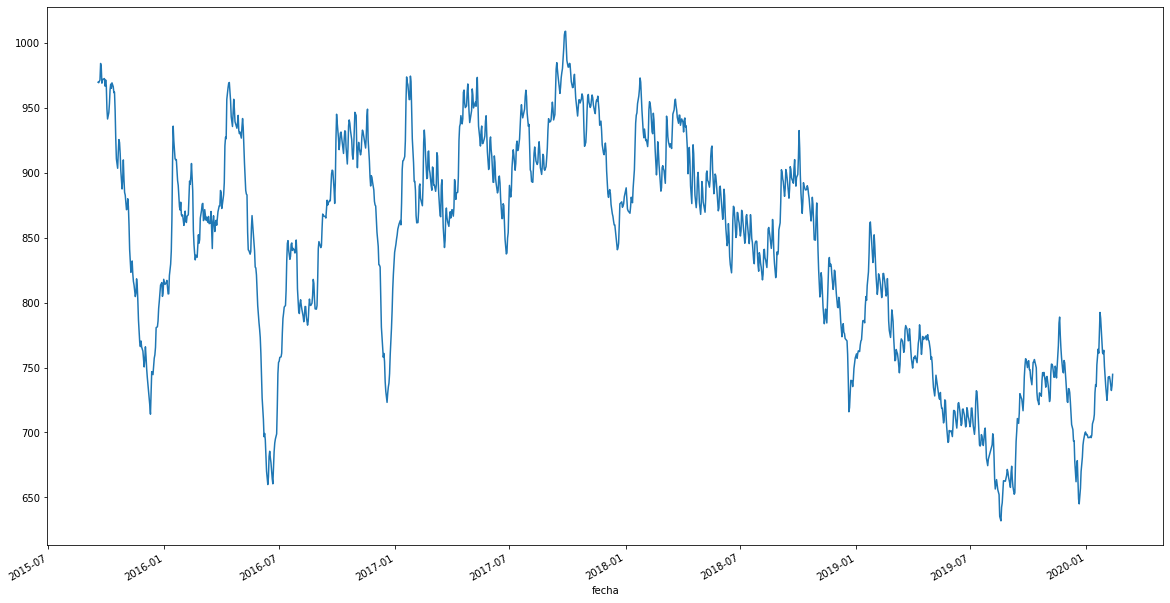

In [ ]:
plt.rcParams["figure.figsize"] = (20,11)
res = seasonal_decompose(df_ventas['udsVenta'],model='additive', freq=28)
res.trend.plot()
plt.show()

**Aunque con el filtro de ventas distintas a 0 se pierden registros, para el conjunto de validación y test pasa de 2 meses y medio por producto a 2 meses, por tanto, se mantienen los periodos**

Se hace zoom y se observa se indican que serán los periodos de Validacion y Test

In [ ]:
fechaA="2019-08-31"
FechaB="2019-11-15"
FechaFin="2020-01-30"

In [ ]:
A=df_ventas.loc[(df_ventas.index>fechaA)&(df_ventas.index<FechaB)]

In [ ]:
A.shape

(63, 2)

In [ ]:
B=df_ventas.loc[(df_ventas.index>FechaB)&(df_ventas.index<FechaFin)]

In [ ]:
B.shape

(62, 2)

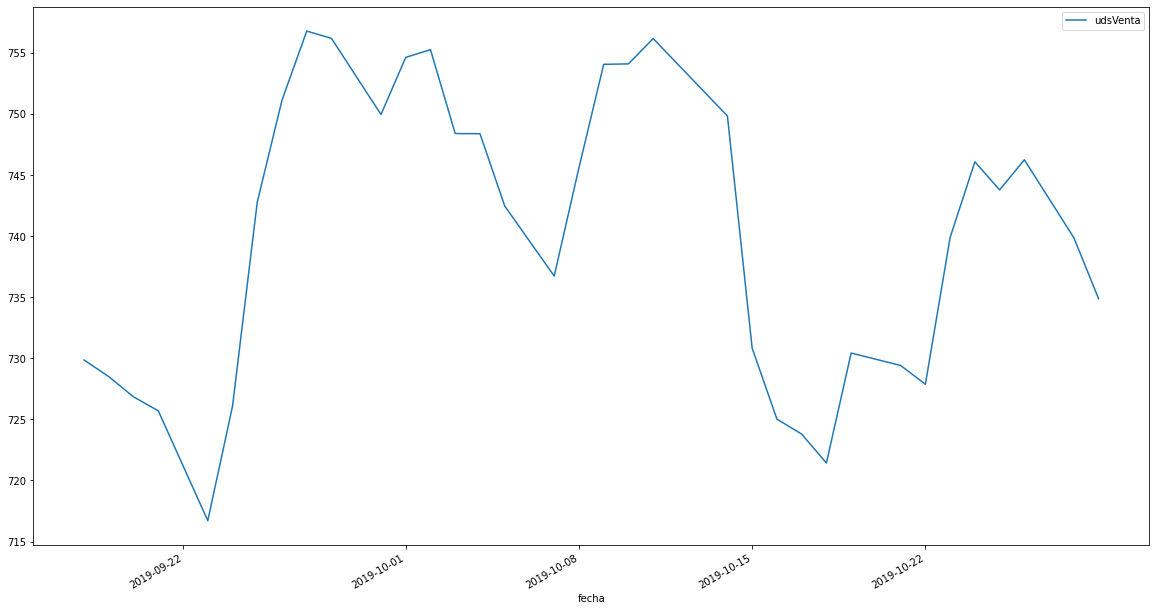

In [ ]:
plt.rcParams["figure.figsize"] = (20,11)
res = seasonal_decompose(A['udsVenta'],model='additive', freq=28)

res.trend.plot()
plt.legend()
plt.show()

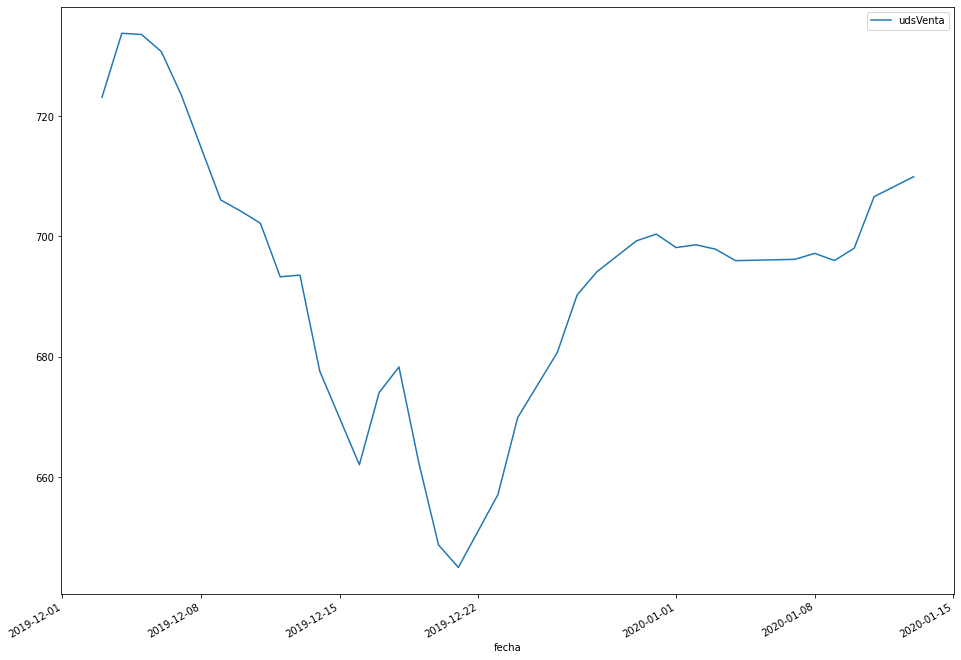

In [ ]:


plt.rcParams['figure.figsize'] = [16, 12]
res = seasonal_decompose(B['udsVenta'],model='additive', freq=28)

res.trend.plot()
plt.legend()
plt.show()

### Definición de los periodos

Visualizamos los diferentes periodos.
 - Azul: Conjunto de entrenamiento
 - Naranja: Conjunto de validación con lo que trabajará el modelo.
 - Verde: Conjunto de Test: Para evaluar la solución. Este conjunto de datos no será utilizado por el modelo y servirá para evitar overfitting

- Las fechas serán de entrenamiento desde 2015-08-31 hasta 2019-08-31
- Fecha de validación desde 2019-08-31 hasta 2019-11-15
- Fecha del conjunto de test desde 2019-11-15 hasta 2020-01-30

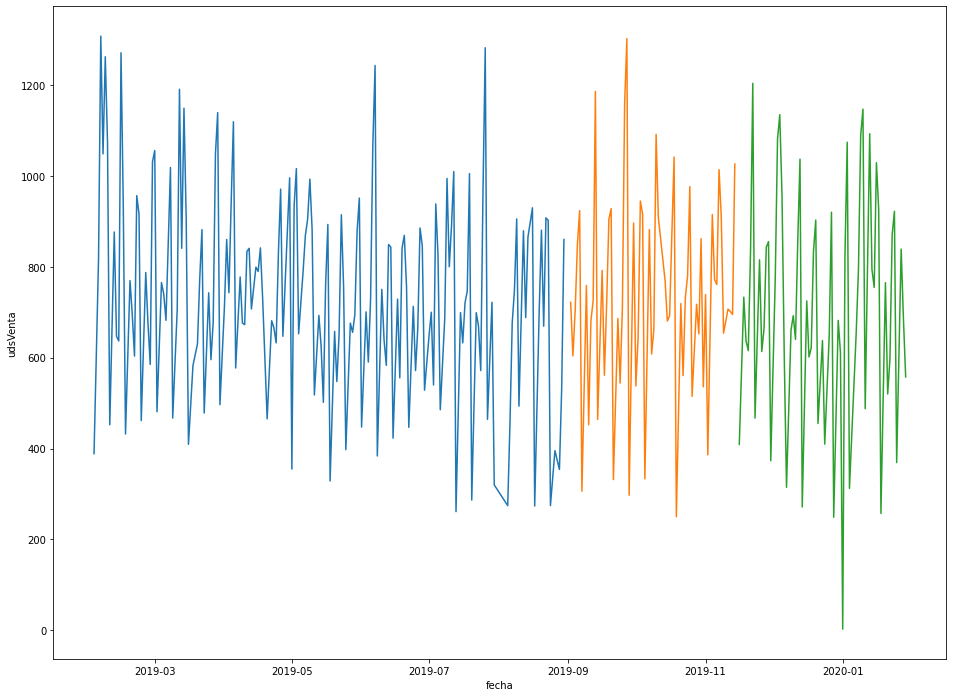

In [ ]:

sns.lineplot(x = "fecha", y = "udsVenta", data = df_ventas.loc[(df_ventas.index>"2019-02-01")&(df_ventas.index<fechaA)])
sns.lineplot(x = "fecha", y = "udsVenta", data = df_ventas.loc[(df_ventas.index>fechaA)&(df_ventas.index<FechaB)])
sns.lineplot(x = "fecha", y = "udsVenta",data=df_ventas.loc[(df_ventas.index>FechaB)&(df_ventas.index<FechaFin)])



#5 Feature Engineering Final

- Se seleccionan las fechas.
- Eliminación de variables no necesarias.
- Inputación de nulos.
    - UpperBand_monthly se sustituye los nulos por el UpperBand_weekly
    - Media_W4 se sustituye por Media_W2.
    - Se elimina la variable Media_W2
    

In [ ]:
df=df.loc[(df["fecha"]>'2015-08-31')&(df["fecha"]<'2020-01-30')]

In [ ]:
df = df.drop(["udsPrevisionEmpresa"], axis = 1)


In [ ]:
df = df.drop(["categorias"], axis = 1)


In [ ]:
df.isna().sum()

producto               0
fecha                  0
promocion              0
festivo                0
precio                 0
pre_promocion          0
udsVenta               0
weekday_Friday         0
weekday_Monday         0
weekday_Saturday       0
weekday_Thursday       0
weekday_Tuesday        0
weekday_Wednesday      0
w_1                    0
w_2                    0
w_3                    0
w_4                    0
Media_W4             337
Media_W2             109
Mediana_7D            72
UpperBand_weekly      72
UpperBand_monthly    348
rsi_cat_1              0
rsi_cat_2              0
rsi_cat_3              0
dtype: int64

In [ ]:
df.loc[df["UpperBand_monthly"].isna(),"UpperBand_monthly"]=df.loc[df["UpperBand_monthly"].isna(),"UpperBand_weekly"]

In [ ]:
df.loc[df["Media_W4"].isna(),"Media_W4"]=df.loc[df["Media_W4"].isna(),"Media_W2"]

In [ ]:
df.fillna(method="ffill",inplace=True)

In [ ]:
df = df.drop(["Media_W2"], axis = 1)


In [ ]:
df.columns

Index(['producto', 'fecha', 'promocion', 'festivo', 'precio', 'pre_promocion',
       'udsVenta', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'w_1',
       'w_2', 'w_3', 'w_4', 'Media_W4', 'Mediana_7D', 'UpperBand_weekly',
       'UpperBand_monthly', 'rsi_cat_1', 'rsi_cat_2', 'rsi_cat_3'],
      dtype='object')

In [ ]:
fechaA="2019-08-31"
FechaB="2019-11-15"
FechaFin="2020-01-30"

In [ ]:
df=df.loc[~df["producto"].isin([80, 81,83,92,93,99])]

In [ ]:
df_train_ohe=df.loc[(df["fecha"]<=fechaA)]

In [ ]:
df_train_ohe.shape

(69905, 24)

In [ ]:
df_val=df.loc[(df["fecha"]>fechaA)&(df["fecha"]<FechaB)]

In [ ]:
df_val.shape

(3831, 24)

In [ ]:
df_estim=df.loc[(df["fecha"]>=FechaB)&(df["fecha"]<FechaFin)]

In [ ]:
df_entrenar = df_train_ohe
df_validacion = df_val


Se eliminan los productos 80, 81,83,92,93 y 99 por no tener muestra suficientes distintas de 0s

# 6 Escalado de los datos
### Método Elegido : Estandarización del modelo

Se descarta Min_Max Scaler debido a que es sensible a los valores atípicos, como en este caso hay valores atípicos, por ejemplo, en los datos en promociones y son útiles para el modelo se descarta esta opción. Mediante la estandarización todas las características estarán  en la misma escala en relación con las demás.


In [ ]:
scaler=StandardScaler()

# 7 CREACIÓN MODELO SOLUCIÓN

In [ ]:
import math
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix,mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import lightgbm


In [ ]:
!pip install catboost


In [ ]:
from catboost import CatBoostRegressor
import catboost as cgb

In [ ]:
### Definición de metricas para validar el modelo

In [ ]:

def mean_absolute_percentage_error2(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
def smape(A, F):
    return 100./len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
products_id = df_train_ohe['producto'].drop_duplicates()

In [ ]:
products_id

64         1
1891       2
3843       3
5938       4
8032       5
          ..
124063    91
129412    94
131507    96
133602    97
135697    98
Name: producto, Length: 64, dtype: int64

In [ ]:
col_names = ['precio', 'Media_W4','Mediana_7D',"UpperBand_weekly","UpperBand_monthly","udsVenta"]

In [ ]:
feature_columns=['promocion', 'festivo', 'precio', 'pre_promocion',
       'Media_W4', 'Mediana_7D', 'UpperBand_weekly', 'UpperBand_monthly',
       'udsVenta', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
     'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'w_1', 'w_2', 'w_3', 'w_4', 'rsi_cat_1',
       'rsi_cat_2', 'rsi_cat_3']

In [ ]:
cat_columns=['promocion', 'festivo','pre_promocion',
       'weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
     'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'w_1', 'w_2', 'w_3', 'w_4', 'rsi_cat_1',
       'rsi_cat_2', 'rsi_cat_3']

Función Maestra que contiene todas las metricas

In [ ]:
def final_metric2(test_y, pred_y):
    metrics = {}
    preds =np.ceil(pred_y)
    metrics['RMSE'] = mean_squared_error(test_y, preds, squared=False)
    metrics['rRMSE'] = metrics['RMSE']/np.mean(test_y)
    metrics['MAE'] =mean_absolute_error(test_y, preds)
    metrics['MAPE'] =mean_absolute_percentage_error2(test_y, preds)
    metrics['sMAPE'] =smape(test_y, preds)

    print("RMSE: {}\nrRMSE: {}\nMAE: {}\nMAPE: {}\nsMAPE: {}".format(
        metrics['RMSE'], metrics['rRMSE'],metrics['MAE'],metrics['MAPE'],metrics['sMAPE'])
    )
    return metrics

Función que inverte el escalado generado

In [ ]:
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

### Creacion de Dataframes para guardar preciciones y guardar métricas

In [ ]:
a=np.zeros((df_estim.shape[0],))


In [ ]:
df_estim.shape[0]

3744

In [ ]:
df_validaciones = pd.DataFrame(index=df_val.index, data=np.zeros((df_val.shape[0],)), columns= ['predictions'])


In [ ]:
df_predictions = pd.DataFrame(index=df_estim.index, data=np.zeros((df_estim.shape[0],)), columns= ['predictions'])


In [ ]:
df_predictions["producto"]=df_estim[["producto"]]

In [ ]:
df_validaciones["producto"]=df_val[["producto"]]

In [ ]:
df_metricas_val = pd.DataFrame(columns=['producto','modelo','RMSE', 'rRMSE','MAE','MAPE','sMAPE'])

In [ ]:
df_metricas_pred= pd.DataFrame(columns=['producto','modelo','RMSE', 'rRMSE','MAE','MAPE','sMAPE'])

In [ ]:
df_metricas_pred


,producto,modelo,RMSE,rRMSE,MAE,MAPE,sMAPE


In [ ]:
def metricas_totales_val(diccionario,cadena):
  for i in diccionario:
    row = [i, cadena, diccionario[i]['metrics']['RMSE'],diccionario[i]['metrics']['rRMSE'],diccionario[i]['metrics']['MAE'],diccionario[i]['metrics']['MAPE'],diccionario[i]['metrics']['sMAPE']]
    df_metricas_val.loc[len(df_metricas_val)] = row

In [ ]:
def metricas_totales_pred(diccionario,cadena):
  for i in diccionario:
    row = [i, cadena, diccionario[i]['metrics']['RMSE'],diccionario[i]['metrics']['rRMSE'],diccionario[i]['metrics']['MAE'],diccionario[i]['metrics']['MAPE'],diccionario[i]['metrics']['sMAPE']]
    df_metricas_pred.loc[len(df_metricas_pred)] = row

# 8 Estructura de la solución

A continuación, se comenta como se estructura  cada ejecución del modelo. Será un modelo por producto y por tipología de modelo:

 

1.   Se define la función del modelo 
2.  Se crea un bucle donde cada iteración se ejecuta desde el paso 3 hasta el final una vez por producto.
3. Se define el conjunto de entrenamiento por producto, escalando las variables númericas y posteriormente se concatena con las variables categoricas. 
4. El paso 3 se realiza para conjunto de validación y test.
5. Se ejecuta el modelo llamando a la función definida en el paso 1. En este paso se entrena se elige el mejor modelo para cada producto con el conjunto de entrenamiento y validación. Esta función devuelve el modelo, las métricas de validación y las prediciones de validación.
6. Este modelo y metricas de validación se guardan en un diccionario y las prediciones se guardan en un dataset.
7. Se realiza la predicción con el conjunto de test, este conjunto de datos el modelo no lo conoce y se observa que tan bueno es el modelo con el conjunto de validación.
8. Las métricas, modelo y validación se guardan para su futura evaluación con los distintos modelos por producto
9. Cada Salida del modelo nos irá indicando las diferentes métricas tanto de validación como test




# 9 Selección de Indicadores de precisión.

$$ MAE = (\frac{1}{n})\sum_{i=1}^{n}\left | y_{i} - x_{i} \right |$$
$$MAPE = \frac{1}{n}\sum_{t=1}^n \lvert \frac{A_t-F_t}{A_t}|$$

En este segundo ejercicio al intentar predecir una demanda distinta de cero se procede a usar los indicadores MAE y MAPE como principales.
MAE Error Porcentual Absoluto Medio (MAPE o Mean Absolute Percentage Error) es un indicador del desempeño que mide el  error en términos porcentuales mientras que MAE mide la magnitud promedio de los errores de las predicciones

Interpretación de los valores de MAPE *Fuente: Lewis (1982, p. 40)*

| MAPE   	| Interpretation                	|
|--------	|-------------------------------	|
| <10    	| Highly   accurate forecasting 	|
| 10-20 	| Good   forecasting            	|
| 20-50  	| Reasonable   forecasting      	|
| >50    	| Inaccurate   forecasting      	|

#10 Selección de modelos

Dado que en el Notebook anterior tanto SVR como Sarimax son los peores modelos se dedicen eliminar de este análisis

* Indicar que hay ciertos productos que tienen muy pocos días de venta en las franjas seleccionadas y puede ser un problema de cara a la realización del modelo con algún producto*

 Los modelos seleccionados son:

 - XGBoost
 - Stacking 2 XGBoost
 - Stacking LightGBM- XGBoost - CatBoostRegressor - Perceptrón multicapa 
 - Vanilla LSTM


# 10.1 XGBoost 

El XGBoost es un popular modelo de aprendizaje automático con características buenas carácteristicas como velocidad de cálculo, paralelización y rendimiento.
Su principal ventaja es que en cada iteración este modelo se ajusta
empleando únicamente una fracción del set de entrenamiento, extraída de forma aleatoria y sin reemplazo (no con bootstrapping). 
A este resultado de de las posibles modificaciones se llama Stochastic Gradient Boosting y proporciona dos ventajas: mejora la predicción y permite estimar el out-of-bag-error de forma que cada modelo aprende de los errores del anterior.


Además se  usa este modelo por la capacidad de extraer las caracteristicas de manera individualizada de la serie temporal



En esta sección, utilizaremos XGBRegressor y Grid Search para afinar y recuperar los parámetros óptimos para reducir el rmse.

Buscamos los mejores hiperparametrós ya que una vez seleccionado el mejor modelo de manera invidual se usará en los siguientes modelos.

Destacamos la búsqueda de hyperparametros en:
- learning_rate: reduce la contribución de cada árbol multiplicando su influencia original por este valor.
- max_depth: profundidad máxima que pueden alcanzar los árboles.

- subsample: proporción de observaciones utilizadas para el ajsute de cada árbol. Si su valor es inferior a 1, se está aplicando Stochastic Gradient Boosting.
- n_estimators: número de árboles incluidos en el modelo.
- Destacar el parametro Alpha para prevenir el overfitting y hacer el modelo más conservativo



In [ ]:
def get_clf_xgb(X, y, X_val, y_val):
    tscv = TimeSeriesSplit(n_splits=3)

    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 250],
        'alpha': [10],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = tscv,
                           n_jobs = -1,
                           verbose = 0)

    gsearch.fit(X,y)
    print(gsearch.best_params_)
    xlf_1=  gsearch.best_estimator_        

    #xlf_1 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.6, learning_rate = 0.01, max_depth = 13, alpha = 10, n_estimators = 240, echo=False)
    xlf_1.fit(X, y, eval_metric="rmse", eval_set = [(X_val, y_val)],verbose=0)
    preds = xlf_1.predict(X_val)
    
    return xlf_1,preds

In [ ]:
model_dict_val_XGB = {}
model_dict2= {}

# For product p id in all products id
for p in products_id:
  
      ## Generate model for product p
      print("Generando modelo para producto: {}".format(p))
      #train
      temp_df = df_entrenar[df_entrenar['producto']==p].drop(['fecha', 'producto'], axis=1)
      features = temp_df[col_names]

      scaler = scaler.fit(features.values)

      features = scaler.transform(features.values)
      features2=np.array(temp_df[cat_columns])

      fetures_train=np.concatenate([features2,features], axis=1)

      temp_labels_model = fetures_train[:, -1]
      temp_features_model =fetures_train[:, :-1]
      # validacion
      Val_df_Y = df_validacion[df_validacion['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_Val_Y = Val_df_Y[col_names]
      features_Y = scaler.transform(feat_Val_Y.values)
      features2_val=np.array(Val_df_Y[cat_columns])
      fetures_val=np.concatenate([features2_val,features_Y], axis=1)
      val_labels_model_Y = fetures_val[:, -1]
      val_features_model_Y =fetures_val[:, :-1]

      # Estimar

      Estimar_df = df_estim[df_estim['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_test_Y = Estimar_df[col_names]
      feat_test = scaler.transform(feat_test_Y.values)
      features2_estim=np.array(Estimar_df[cat_columns])
      feat_test_Y_FIN=np.concatenate([features2_estim,feat_test], axis=1)
      test_labels_model_Y = feat_test_Y_FIN[:, -1]
      test_features_model_Y =feat_test_Y_FIN[:, :-1]

      print("Shape del dataframe para el producto es: {}".format(temp_df.shape))
      clf, pred_val= get_clf_xgb(temp_features_model, temp_labels_model, val_features_model_Y,val_labels_model_Y)


      val_pred=invTransform(scaler,pred_val,"udsVenta",col_names)
      val_pred[val_pred < 0] = 0
      Y_VAL=invTransform(scaler,features_Y[:, -1],"udsVenta",col_names)
      metricas=final_metric2(Y_VAL,val_pred )



      df_validaciones.loc[Val_df_Y.index, 'predictions_XGB'] = np.ceil(val_pred)

      
      ## Save model into model_dict
      model_product_dict = {'clf': clf, 'metrics': metricas}
      model_dict_val_XGB[p] = model_product_dict


      #Predicion final
      print("### Validaciones Finales###")
      predictions = clf.predict(test_features_model_Y)


      TEST_Y=invTransform(scaler,feat_test[:, -1],"udsVenta",col_names)
      prediciones=invTransform(scaler,predictions,"udsVenta",col_names)
      prediciones[prediciones < 0] = 0
      metrics2=final_metric2(TEST_Y,prediciones )
      print("-----------------------------------------------------")

     #Guardar prediciones
      df_predictions.loc[Estimar_df.index, 'predictions_XGB'] = np.ceil(prediciones)

      ## Save model into model_dict
      model_product_dict = {'clf': clf, 'metrics': metrics2}
      model_dict2[p] = model_product_dict

Generando modelo para producto: 1
Shape del dataframe para el producto es: (1135, 22)
{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.7}
RMSE: 2493.979907629774
rRMSE: 0.7910926471229162
MAE: 1748.084745762712
MAPE: 147.93641320182945
sMAPE: 59.72342598660436
### Validaciones Finales###
RMSE: 2902.3546840219938
rRMSE: 0.911480480320317
MAE: 1654.4406779661017
MAPE: 172.2471556201544
sMAPE: 58.187184855678865
-----------------------------------------------------
Generando modelo para producto: 2
Shape del dataframe para el producto es: (962, 22)
{'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
RMSE: 557.117393663652
rRMSE: 0.29127619117894543
MAE: 421.14516129032256
MAPE: 29.11451303703515
sMAPE: 24.34910639555936
### Validaciones Finales###
RMSE: 415.99253224696946
rRMSE: 0.2336498730911572

In [ ]:
metricas_totales_val(model_dict_val_XGB,"XGB")

In [ ]:
metricas_totales_pred(model_dict2,"XGB")

**Conclusiones Modelo:** Este modelo se adapta bien en estimar la demanda en algunos productos, se queda un poco corto en otros pero podría ser una buena solución comparandose con la previsión de la demana que usa la empresa

# 10.2 STACKING XGBOOST

Las tecnicas de Stacking  combinar mejor las predicciones de dos o más algoritmos de aprendizaje automático básicos

El beneficio del apilamiento es que puede aprovechar las capacidades de una serie de modelos de buen rendimiento en una tarea de regresión y hacer predicciones que tienen un mejor rendimiento que cualquier modelo individual en el conjunto.

Por ello se decide usar un stacking de dos XGBoost básicos apilados. Estos modelos XGBoost serán el mejor modelo XGBoostbásico de cada producto. 

In [ ]:
def get_stacked_clf( p):
  
    estimators = [
        ('xgb_1', model_dict2[p]['clf']),
        ('xgb_2', model_dict2[p]['clf'])
        
    ]
    sclf = StackingRegressor(
        estimators=estimators,
        final_estimator=RandomForestRegressor(n_estimators=20),
        cv=5)
    return sclf

In [ ]:
def get_clf2(X, y, X_test, y_test,p):
    #test_x, val_x, test_y, val_y = train_test_split(X_test, y_test, test_size = 0.5)

    xlf = get_stacked_clf(p)
    xlf.fit(X, y)

    # calculate the auc score
    preds = xlf.predict(X_test)

    return xlf,preds

In [ ]:
model_dict_val_XGB2 = {}
model_dict_test_XGB2 = {}
# For product p id in all products id
for p in products_id:
      ## Generate model for product p
      print("Generando modelo para producto: {}".format(p))
      #train
      temp_df = df_entrenar[df_entrenar['producto']==p].drop(['fecha', 'producto'], axis=1)
      features = temp_df[col_names]

      scaler = scaler.fit(features.values)

      features = scaler.transform(features.values)
      features2=np.array(temp_df[cat_columns])

      fetures_train=np.concatenate([features2,features], axis=1)

      temp_labels_model = fetures_train[:, -1]
      temp_features_model =fetures_train[:, :-1]
      # validacion
      Val_df_Y = df_validacion[df_validacion['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_Val_Y = Val_df_Y[col_names]
      features_Y = scaler.transform(feat_Val_Y.values)
      features2_val=np.array(Val_df_Y[cat_columns])
      fetures_val=np.concatenate([features2_val,features_Y], axis=1)
      val_labels_model_Y = fetures_val[:, -1]
      val_features_model_Y =fetures_val[:, :-1]

      # Estimar

      Estimar_df = df_estim[df_estim['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_test_Y = Estimar_df[col_names]
      feat_test = scaler.transform(feat_test_Y.values)
      features2_estim=np.array(Estimar_df[cat_columns])
      feat_test_Y=np.concatenate([features2_estim,feat_test], axis=1)
      test_labels_model_Y = feat_test_Y[:, -1]
      test_features_model_Y =feat_test_Y[:, :-1]

      print("Shape del dataframe para el producto es: {}".format(temp_df.shape))
      clf,pred_val= get_clf2(temp_features_model, temp_labels_model, val_features_model_Y,val_labels_model_Y,p)
      

      val_pred=invTransform(scaler,pred_val,"udsVenta",col_names)
      val_pred[val_pred < 0] = 0

      y_val=invTransform(scaler,features_Y[:, -1],"udsVenta",col_names)
      metrics = final_metric2(y_val, val_pred)
      df_validaciones.loc[Val_df_Y.index, 'predictions_XGB2'] = np.ceil(val_pred)


      ## Save model into model_dict
      model_product_dict = {'clf': clf, 'metrics': metrics}
      model_dict_val_XGB2[p] = model_product_dict


      #Predicion final
      print("### Validaciones Finales###")
      predictions = clf.predict(test_features_model_Y)
      TEST_Y=invTransform(scaler,feat_test_Y[:, -1],"udsVenta",col_names)

      prediciones=invTransform(scaler,predictions,"udsVenta",col_names)
      prediciones[prediciones < 0] = 0

      metricas=final_metric2(TEST_Y,prediciones )
      print("-----------------------------------------------------")

     #Guardar prediciones
      df_predictions.loc[Estimar_df.index, 'predictions_XG2'] = np.ceil(prediciones)
      model_product_dict = {'clf': clf, 'metrics': metricas}
      model_dict_test_XGB2[p] = model_product_dict



Generando modelo para producto: 1
Shape del dataframe para el producto es: (1135, 22)
RMSE: 3236.7541415562223
rRMSE: 1.0267012954259476
MAE: 1823.3389830508474
MAPE: 120.24479586031309
sMAPE: 56.23572459623128
### Validaciones Finales###
RMSE: 2909.879760460728
rRMSE: 0.9138437201836543
MAE: 1530.3559322033898
MAPE: 110.28493773029118
sMAPE: 53.31017043140977
-----------------------------------------------------
Generando modelo para producto: 2
Shape del dataframe para el producto es: (962, 22)
RMSE: 827.5068950107441
rRMSE: 0.4326432082258119
MAE: 576.016129032258
MAPE: 39.5506340827197
sMAPE: 33.171259697466844
### Validaciones Finales###
RMSE: 699.4411000641986
rRMSE: 0.392853985580002
MAE: 555.4262295081967
MAPE: 43.60668596810905
sMAPE: 36.13750549172584
-----------------------------------------------------
Generando modelo para producto: 3
Shape del dataframe para el producto es: (1123, 22)
RMSE: 1420.0724765693044
rRMSE: 0.5934876984132016
MAE: 917.7741935483871
MAPE: 43.23834

In [ ]:
metricas_totales_val(model_dict_val_XGB2,"XGB2")

In [ ]:
metricas_totales_pred(model_dict_test_XGB2,"XGB2")

**Conclusiones del modelo** En esta caso en particular. Dos niveles de dos modelos XGBoost similares no indican mejoría respecto el XGBoost normal. Seguiría siendo una buena solución pero es mejor el XGBoost básico

# 10.3 STACKING 2 LightGBM, XGB, CatBoost + MLPRegressor

Dado que los resultados no varían mucho del Stacking XGBoost con el modelo básico se decide realizar un stacking más complejo basandose en Gradient Boosting


Se introducen los modelos LightGBM y CatBoost.
Se introduce como primer modelo el LightGBM debido a que tiene una ligera diminución de rendimiento predictivo para dar un aumento de la velocidad de entrenamiento mucho mayor. Esto significa una mayor oportunidad para la ingeniería de características y esto, produce mayores incrementos en el rendimiento predictivo con los otros modelos

En la segunda capa del ensamblado tenemos el mejor modelo básico XGBoost y en en el siguiente nivel usamos CatBoost ya que tiene gran capacidad de predección con variables categoricas como ocurre en nuestro caso mediante codificación one-hot. [Publicación](https://arxiv.org/pdf/1706.09516.pdf//)

Por último, se usa una Red neuronal sencilla ANN que consiste en una capa de entrada una capa oculta y a capa de salida llamada MLP


In [ ]:
def get_clf3(X, y, X_test, y_test,p):
    #test_x, val_x, test_y, val_y = train_test_split(X_test, y_test, test_size = 0.5)

    xlf = get_stacked_clf2(p)
    xlf.fit(X, y)

    # calculate the auc score
    preds = xlf.predict(X_test)
  
    return xlf,preds

In [ ]:
def get_stacked_clf2(p):
  RANDOM_SEED=10
  param_lgbm = {
      'feature_fraction': 0.3,
      'learning_rate': 0.03,
      'max_depth': 7,
      'min_child_weight': 41,
      'min_split_gain': 0.04,
      'num_leaves':46,
      'application':'regression',
      'num_iterations': 5000,
      'metric': 'rmse'
  }

  param_cat = {
      'bagging_temperature': 0.32,
      'depth': 8,
      'l2_leaf_reg': 1.35,
      'learning_rate': 0.2,
      'iterations': 100,
      'loss_function': 'RMSE',
      'verbose': False
  }

  estimators = [
          ('lgbm', lightgbm.LGBMRegressor(**param_lgbm, random_state=RANDOM_SEED, n_jobs=-1)),
          ('xgbr', model_dict2[p]['clf']),
          ('cat', CatBoostRegressor(**param_cat)),
          ('mlp', MLPRegressor()) 
  ]

  sclf = StackingRegressor(
      estimators=estimators,
      final_estimator=LinearRegression(),
      n_jobs=-1,
      cv=5
  )

  return sclf

In [ ]:
model_dict_val_STCK2 = {}
model_dict_test_STCK2 = {}
# For product p id in all products id
for p in products_id:
      ## Generate model for product p
      print("Generando modelo para producto: {}".format(p))
      #train
      temp_df = df_entrenar[df_entrenar['producto']==p].drop(['fecha', 'producto'], axis=1)
      features = temp_df[col_names]

      scaler = scaler.fit(features.values)

      features = scaler.transform(features.values)
      features2=np.array(temp_df[cat_columns])

      fetures_train=np.concatenate([features2,features], axis=1)

      temp_labels_model = fetures_train[:, -1]
      temp_features_model =fetures_train[:, :-1]
      # validacion
      Val_df_Y = df_validacion[df_validacion['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_Val_Y = Val_df_Y[col_names]
      features_Y = scaler.transform(feat_Val_Y.values)
      features2_val=np.array(Val_df_Y[cat_columns])
      fetures_val=np.concatenate([features2_val,features_Y], axis=1)
      val_labels_model_Y = fetures_val[:, -1]
      val_features_model_Y =fetures_val[:, :-1]

      # Estimar

      Estimar_df = df_estim[df_estim['producto']==p].drop(['fecha', 'producto'], axis=1)
      feat_test_Y = Estimar_df[col_names]
      feat_test = scaler.transform(feat_test_Y.values)
      features2_estim=np.array(Estimar_df[cat_columns])
      feat_test_Y=np.concatenate([features2_estim,feat_test], axis=1)
      test_labels_model_Y = feat_test_Y[:, -1]
      test_features_model_Y =feat_test_Y[:, :-1]

      print("Shape del dataframe para el producto es: {}".format(temp_df.shape))
      clf,pred_val= get_clf3(temp_features_model, temp_labels_model, val_features_model_Y,val_labels_model_Y,p)
      

      val_pred=invTransform(scaler,pred_val,"udsVenta",col_names)
      val_pred[val_pred < 0] = 0

      y_val=invTransform(scaler,features_Y[:, -1],"udsVenta",col_names)
      metrics = final_metric2(y_val, val_pred)
      df_validaciones.loc[Val_df_Y.index, 'predictions_STCK2'] = np.ceil(val_pred)
      ## Save model into model_dict
      model_product_dict = {'clf': clf, 'metrics': metrics}
      model_dict_val_STCK2[p] = model_product_dict


      #Predicion final
      print("### Validaciones Finales###")
      predictions = clf.predict(test_features_model_Y)
      TEST_Y=invTransform(scaler,feat_test_Y[:, -1],"udsVenta",col_names)
      prediciones=invTransform(scaler,predictions,"udsVenta",col_names)
      prediciones[prediciones < 0] = 0
      metricas=final_metric2(TEST_Y,prediciones )
      print("-----------------------------------------------------")

     #Guardar prediciones
      df_predictions.loc[Estimar_df.index, 'predictions_STCK2'] = np.ceil(prediciones)

      model_product_dict = {'clf': clf, 'metrics': metricas}
      model_dict_test_STCK2[p] = model_product_dict

Generando modelo para producto: 1
Shape del dataframe para el producto es: (1135, 22)
RMSE: 2311.0183095593693
rRMSE: 0.7330570653218932
MAE: 1491.6271186440679
MAPE: 100.09645864602139
sMAPE: 79.4813475151412
### Validaciones Finales###
RMSE: 2593.4661709112415
rRMSE: 0.8144744693577081
MAE: 1315.322033898305
MAPE: 108.79543779478142
sMAPE: 43.824460796024475
-----------------------------------------------------
Generando modelo para producto: 2
Shape del dataframe para el producto es: (962, 22)
RMSE: 534.6886190623836
rRMSE: 0.2795498151709964
MAE: 402.0483870967742
MAPE: 25.4310472989903
sMAPE: 23.273860499990835
### Validaciones Finales###
RMSE: 374.3568035890928
rRMSE: 0.21026439868270028
MAE: 289.7049180327869
MAPE: 24.602906629643922
sMAPE: 20.75373795581965
-----------------------------------------------------
Generando modelo para producto: 3
Shape del dataframe para el producto es: (1123, 22)
RMSE: 636.286808935881
rRMSE: 0.2659219159562431
MAE: 468.16129032258067
MAPE: 28.37

In [ ]:
metricas_totales_val(model_dict_val_STCK2,"STCK2")

In [ ]:
metricas_totales_pred(model_dict_test_STCK2,"STCK2")

**Conclusión del modelo:** El Stacking  puede mejorar el rendimiento del modelo.
Reduce la varianza y crea un modelo más robusto al combinar las predicciones de varios modelos, lo que se traduce en que el conjunto de test las métricas no varian tanto y algunos modelos de los productos son muy buenos.
 
Esto es debido en parte a los modelos utilizados que parten del Gradient Boosting pero son utiles para las caracteristicas que se usan en el modelo.

A simple este modelo sería el mejor que predice la demanda de los anteriores estudidados

# 10.4 LSTM


Las redes recurrentes son la solución más utilizada para resolver los problemas de explosión y desaparición del gradiente. Esto consiste en utilizar celdas en las que existe una conexión entre el estado anterior y la salida de la celda a la cual no se aplican funciones no lineales. En este tipo de celdas se controla la información que fluye por esta conexión directa utilizando puertas lógicas modeladas con neuronas completamente conectadas.

Como hemos observado en el análisis gráfico y estadistico existe cierta relación entre los días (semanas) anteriores y la demanda actual. Por tanto, se realiza un modelo básico de red recurrente con una arquitectura LSTM



Se usa LSTM y no otra arquitectura debido a que las secuencias que se observan en el pasado pueden tener dependencia muy separadas a parte de la relación semanal, también promociones y festivos que normalmente se encuentran en periodos muy lejanos.

Las entradas a la celda LSTM son el valor correspondiente y la salida de los pasos anteriores

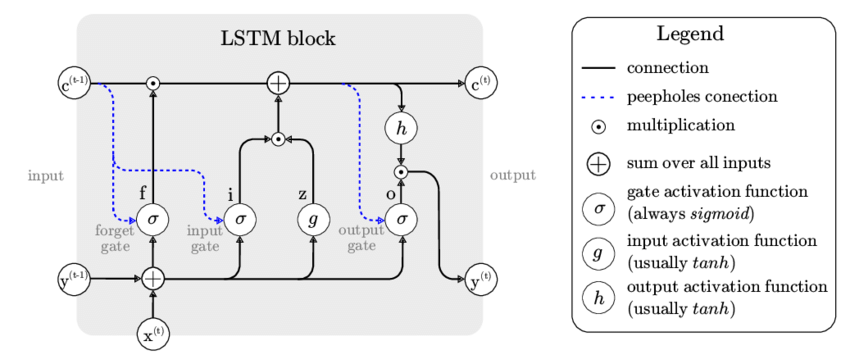

*Van Houdt, Greg & Mosquera, Carlos & Nápoles, Gonzalo. (2020). A Review on the Long Short-Term Memory Model. Artificial Intelligence Review. 53. 10.1007/s10462-020-09838-1.*

En esto caso usamos Una Vanilla LSTM es un modelo LSTM que tiene una sola capa oculta de unidades LSTM, y una capa de salida utilizada para hacer una predicción.

Para el desarrolo del modelo se necesita:
-  Alterar la entrada para poder entranarla con "backpropagation" y generar nuevas entradas.

- La estructura es similar, mantiendo las mismas fechas en entranamiento test y validación sólo que en este modelo se generán las entradas y posteriormente se divide.

- Se obtienen 6 días previos para posteriormente predecir la demanda del séptimo, esto es así porque se eliminan el domingo del conjunto de datos.

- De entrada a la red neuronal con 6 columnas en donde se incluye la cantidad de unidades vendidas en los 6 días anteriores más todas las caracteristicas y de salida la cantidad de unidades vendidas en la fecha actual

- Esos valores se ajustan con backpropagation al igual que nuestra red neuronal. Y finalmente nuestros datos categóricos y númericos enriquecen al modelo.
- Utilizaremos como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error.

In [ ]:
print(1)

1


In [ ]:
## Definición del conjunto de datos

In [ ]:
df_LSTM=df.loc[(df["fecha"]<FechaB)]

In [ ]:
FechaB

'2019-11-15'

In [ ]:
Nueva_Fecha='2019-11-08'

Para que el conjuto de datos de test pueda generar una predición el modelo necesita los 6 días anteriores a la primera predición de la demanda y luego estas fechas se extraén del conjunto de datos de test. El problema en este caso que se filtran por ventas distintas de cero en estos 6 se pueden haber eliminado fechas y producir algún tipo de error

In [ ]:
Nueva_Fecha

'2019-11-08'

In [ ]:
df_estim_LSTM=df.loc[(df["fecha"]>=Nueva_Fecha)&(df["fecha"]<FechaFin)]

In [ ]:
PASOS=6
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    print(data.shape)
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    return agg

*Dado que existen productos con ventas a 0s en estos días la back propagation lleva a errores a la hora de juntar las prediciones con el resto, por tanto se calculan las metricas y prediciones de manera habitual, pero no se guardan las prediciones de los productos desde id 80 al 99*

Se elimina el producto 93 al no tener suficiente muestra

In [ ]:
model_LSTM_val = {}
model_LSTM_test = {}
model_LSTM_prediciones={}
# For product p id in all products id
for p in products_id:
      ## Generate model for product p


      Val_df_Y = df_validacion[df_validacion['producto']==p].drop(['fecha', 'producto'], axis=1)
      validacion=df_validacion[df_validacion['producto']==p].shape[0]
      print("Generando modelo para producto: {}".format(p))
      #Generacion de datasets
      temp_df = df_LSTM[df_LSTM['producto']==p].drop(['fecha', 'producto'], axis=1)
      features = temp_df[col_names]

      scaler = scaler.fit(features.values)

      features = scaler.transform(features.values)
      features2=np.array(temp_df[cat_columns])


      reframed = series_to_supervised(features[:, -1].reshape(-1, 1), PASOS, 1)

      fetures=np.concatenate([features2,features[:, :-1],np.array(reframed)], axis=1)
      fetures = fetures[~np.isnan(fetures).any(axis=1)]
      labels = fetures[:, -1]
      X =fetures[:, :-1]

      # valid
      valid_data = X[X.shape[0]-validacion:X.shape[0]]
      valid_target=labels[labels.shape[0]-validacion:labels.shape[0]]

      # train
      training_data = X[0:X.shape[0]-validacion]
      target_data=labels[0:labels.shape[0]-validacion]
      x_train = training_data.reshape((training_data.shape[0], 1, training_data.shape[1]))
      val_X = valid_data.reshape((valid_data.shape[0], 1, valid_data.shape[1]))
      
      #Modelo.
      model = Sequential()
      model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
      model.add(Dense(1))
      model.compile(loss='mae', optimizer='adam')
      history = model.fit(x_train, target_data, epochs=50, batch_size=72, validation_data=(val_X, valid_target), verbose=0, shuffle=False)
      print(val_X.shape)
      # make a prediction con val
      yhat = model.predict(val_X)
      val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
      # invert scaling for forecast
      val_pred=invTransform(scaler,yhat,"udsVenta",col_names)
      val_pred[val_pred < 0] = 0
      val_pred=np.ceil(val_pred)
      val_Y=invTransform(scaler,valid_target,"udsVenta",col_names)
      metricas=final_metric2( val_Y,val_pred)

      df_validaciones.loc[Val_df_Y.index, 'predictions_LSTM'] = np.ceil(val_pred)

      model_product_dict = {'clf': history, 'metrics': metricas}
      model_LSTM_val[p] = model_product_dict


      xx=df_estim_LSTM[df_estim_LSTM['producto']==p].shape[0]-df_predictions.loc[df_predictions.producto==p].shape[0]
      print(xx)
      #make a prediction con test
      if(xx==5):
        df_estim_LSTM=df.loc[(df["fecha"]>='2019-11-07')&(df["fecha"]<FechaFin)]
      elif(xx==2):
        df_estim_LSTM=df.loc[(df["fecha"]>='2019-11-04')&(df["fecha"]<FechaFin)]
      else:
        df_estim_LSTM=df.loc[(df["fecha"]>=Nueva_Fecha)&(df["fecha"]<FechaFin)]


      Estimar_df = df_estim_LSTM[df_estim_LSTM['producto']==p].drop(['fecha', 'producto'], axis=1)
      Estimar_df2 = df_estim[df_estim['producto']==p].drop(['fecha', 'producto'], axis=1)    
      feat_test_Y = Estimar_df[col_names]
      features2test=np.array(Estimar_df[cat_columns])

      feat_test = scaler.transform(feat_test_Y.values)

      reframed2 = series_to_supervised(feat_test[:, -1].reshape(-1, 1), PASOS, 1)
      
      fetures_test=np.concatenate([features2test,feat_test[:, :-1],np.array(reframed2)], axis=1)
      fetures_test = fetures_test[~np.isnan(fetures_test).any(axis=1)]
      labels_test = fetures_test[:, -1]
      X_test =fetures_test[:, :-1]  
      print(X_test.shape)

      final_Test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

      yhat_fin = model.predict(final_Test)

      test_pred=invTransform(scaler,yhat_fin,"udsVenta",col_names)
      test_pred[test_pred < 0] = 0
      test_pred=np.ceil(test_pred)
      TEST_Y=invTransform(scaler,labels_test,"udsVenta",col_names)
      print("### Validaciones Finales###")
      test_metricas=final_metric2( TEST_Y,test_pred)
      print("-----------------------------------------------------")

      
        #model_prediciones = {'prediciones': np.ceil(test_pred)}
        #model_LSTM_test[p] = model_prediciones
     # else:   
      df_predictions.loc[df_predictions.producto==p, 'predictions_LSTM'] = np.ceil(test_pred)
     
      

      model_product_dict = {'clf': history, 'metrics': test_metricas}
      model_LSTM_test[p] = model_product_dict
      df_estim_LSTM=df.loc[(df["fecha"]>=Nueva_Fecha)&(df["fecha"]<FechaFin)]




Generando modelo para producto: 1
(1194, 1)
(59, 1, 27)
RMSE: 1513.908836786976
rRMSE: 0.48021323088155815
MAE: 1065.6271186440679
MAPE: 71.08019076554484
sMAPE: 49.20038394834884
6
(65, 1)
(59, 27)
### Validaciones Finales###
RMSE: 1605.6891123202302
rRMSE: 0.5042644482426243
MAE: 959.1864406779661
MAPE: 68.02376850612106
sMAPE: 73.3489579422
-----------------------------------------------------
Generando modelo para producto: 2
(1024, 1)
(62, 1, 27)
RMSE: 480.91138275623723
rRMSE: 0.2514336070943173
MAE: 381.8225806451613
MAPE: 28.692850183855654
sMAPE: 23.100390235557573
6
(67, 1)
(61, 27)
### Validaciones Finales###
RMSE: 415.07376393623906
rRMSE: 0.2331338299351833
MAE: 322.88524590163934
MAPE: 34.622070525360485
sMAPE: 24.191530841179215
-----------------------------------------------------
Generando modelo para producto: 3
(1185, 1)
(62, 1, 27)
RMSE: 599.1160693189
rRMSE: 0.2503872322921436
MAE: 465.7096774193548
MAPE: 26.06594547174495
sMAPE: 24.423932877652852
6
(68, 1)
(62, 2

In [ ]:
print(1)

1


In [ ]:
metricas_totales_val(model_LSTM_val,"LSTM")

In [ ]:
metricas_totales_pred(model_LSTM_test,"LSTM")

**Conclusiones** Este tipo de Arquitectura aunque es simple se adapta completamente a los datos, lográ entrenarse de una manera bastante precisa y com los datos de test las prediciones son muy buenas. Dado que el batch_size es muy grande en un primer momento se pensaba que podría caer en overfitting pero viendo los resultados en modelo predice la demanda correctamente 

# 10 Conclusiones

In [ ]:
df_metricas_pred.to_csv("/content/gdrive/MyDrive/TFM/3/Metricas_pred_filtrado_25_05.csv", index = False)


In [ ]:
df_metricas_val.to_csv("/content/gdrive/MyDrive/TFM/3/Metricas_val_filtrado_25_05.csv", index = False)


In [ ]:
df_predictions.to_csv("/content/gdrive/MyDrive/TFM/3/prediciones_fin_filtrado_25_05.csv", index = False)


In [ ]:
df_validaciones.to_csv("/content/gdrive/MyDrive/TFM/3/prediciones_val_filtrado_25_05.csv", index = False)


## Conclusiones Generales

In [ ]:
conclusiones=df_metricas_pred[["producto","modelo","MAE","MAPE"]]

In [ ]:
conclusiones.drop_duplicates(inplace=True)

In [ ]:
conclusiones=conclusiones.sort_values(by=["producto","MAPE"])

Se elige como métrica de validación el MAPE estableciendo mejor modelo cuanto menor sea el porcentaje de variación como se ha indicado en el apartado 9

144 Modelos dentro del limite que se indica de MAPE < 50%

In [ ]:
conclusiones.loc[conclusiones["MAPE"]<50]

,producto,modelo,MAE,MAPE
129,2,STCK2,289.704918,24.602907
1,2,XGB,339.524590,34.446244
193,2,LSTM,322.885246,34.622071
65,2,XGB2,555.426230,43.606686
130,3,STCK2,438.096774,41.676420
...,...,...,...,...
56,87,XGB,44.473684,35.599471
248,87,LSTM,36.438596,42.990805
186,89,STCK2,46.260000,41.967843
250,89,LSTM,46.500000,48.427727


26 modelos buenos < 20 %

In [ ]:
conclusiones.loc[conclusiones["MAPE"]<20]

,producto,modelo,MAE,MAPE
196,5,LSTM,204.295082,10.232103
132,5,STCK2,231.409836,11.949438
4,5,XGB,241.672131,12.234345
68,5,XGB2,368.147541,19.061103
208,21,LSTM,54.327869,6.715563
144,21,STCK2,69.967213,8.358836
16,21,XGB,73.049180,8.559148
80,21,XGB2,97.196721,11.917421
152,36,STCK2,60.688525,16.847634
216,36,LSTM,49.885246,18.813479


**cuatro modelos muy buenos**

In [ ]:
conclusiones.loc[conclusiones["MAPE"]<10]

,producto,modelo,MAE,MAPE
208,21,LSTM,54.327869,6.715563
144,21,STCK2,69.967213,8.358836
16,21,XGB,73.049180,8.559148
240,72,LSTM,32.180328,8.670734
176,72,STCK2,36.295082,9.680170


**Indicar que en este caso los resultados estan más igualados que en el modelo anterior esto es debido a la estacionalidad se ha reducido al eliminar los registros con ventas a 0s, pero aun así el mejor modelo sigue siendo el modelo LSTM**

## Mejores Modelos

In [ ]:
best_models=conclusiones.groupby(['producto'], as_index=False)[["modelo",'MAPE']].min()

In [ ]:
best_models

,producto,modelo,MAPE
0,1,LSTM,68.023769
1,2,LSTM,24.602907
2,3,LSTM,41.676420
3,4,LSTM,33.486175
4,5,LSTM,10.232103
5,9,LSTM,73.869511
6,10,LSTM,25.801044
7,11,LSTM,38.686855
8,12,LSTM,27.724225
9,13,LSTM,21.629571


En todos los modelos por producto predice la red Neuronal mejor que los otros modelos excepto en el producto 92 que da un error y se observa que es un producto que no tiene ventas. En la actualización del modelo no se tendrá en cuenta

De 69 productos a priori 35 predicen de una manera adecuada con la creación de una red LSTM simple. Es decir que con 35 productos este modelo sería adecuado para la previsión de la demanda en un escenario normal

In [ ]:
best_models.shape

(64, 3)

In [ ]:
best_models.loc[best_models["MAPE"]<50].shape

(40, 3)

In [ ]:
pd.set_option('display.max_rows', 70)

En este caso 42 modelos de 69 estudiados se pueden considerar modelos aceptables 

In [ ]:
best_models

,producto,modelo,MAPE
0,1,LSTM,68.023769
1,2,LSTM,24.602907
2,3,LSTM,41.676420
3,4,LSTM,33.486175
4,5,LSTM,10.232103
5,9,LSTM,73.869511
6,10,LSTM,25.801044
7,11,LSTM,38.686855
8,12,LSTM,27.724225
9,13,LSTM,21.629571


## Comparación con Previsión de empresa

Se compara erro de la previsión de la empresa con los diferentes modelos




In [ ]:
metricas=pd.read_csv(ruta+"Metricas_pred_filtrado_25_05.csv")


In [ ]:
#metricas.drop_duplicates(inplace=True)

In [ ]:
previsiones=pd.read_csv(ruta+"MODELAR_FINAL.csv")


In [ ]:
previsiones=previsiones.loc[previsiones["udsVenta"]!=0]

In [ ]:
previsiones=previsiones.drop(['weekday_Sunday'],axis=1)

In [ ]:
previsiones=previsiones.loc[~previsiones["producto"].isin([80, 81,83,92,93,99])]

In [ ]:
previsiones=previsiones[["fecha","producto","udsVenta","udsPrevisionEmpresa"]]

In [ ]:
previsiones=previsiones.loc[(previsiones["fecha"]>=FechaB)&(previsiones["fecha"]<FechaFin)]

In [ ]:
previsiones.shape

(3744, 4)

In [ ]:
df_metricas_empresa= pd.DataFrame(columns=['producto','RMSE_empresa', 'rRMSE_empresa','MAE_empresa','MAPE_empresa','sMAPE_empresa'])

In [ ]:
diccionario={}
for p in products_id:
 
    print("Generando Costes para producto: {}".format(p))
    x=final_metric2(previsiones.loc[previsiones["producto"]==p,"udsVenta"],previsiones.loc[previsiones["producto"]==p,"udsPrevisionEmpresa"] )
    model_metrics = { 'metrics': x}
    diccionario[p] = model_metrics

Generando Costes para producto: 1
RMSE: 14709.735241715125
rRMSE: 4.619572038288341
MAE: 11196.101694915254
MAPE: 1328.5523310351846
sMAPE: 121.06212345541766
Generando Costes para producto: 2
RMSE: 7444.143432432166
rRMSE: 4.18114036534563
MAE: 6644.918032786885
MAPE: 641.9506386862072
sMAPE: 125.42821584527037
Generando Costes para producto: 3
RMSE: 8555.827079606566
rRMSE: 4.418816778031814
MAE: 7629.758064516129
MAPE: 673.7557678523347
sMAPE: 127.69867276011456
Generando Costes para producto: 4
RMSE: 14687.926720225345
rRMSE: 4.297694858508641
MAE: 13495.91935483871
MAPE: 556.1688959409943
sMAPE: 129.9880698567938
Generando Costes para producto: 5
RMSE: 8731.135805782453
rRMSE: 4.193497032838839
MAE: 8098.7213114754095
MAPE: 410.17994119694265
sMAPE: 127.52199578288383
Generando Costes para producto: 9
RMSE: 6666.746371606867
rRMSE: 3.76411320714055
MAE: 5408.716666666666
MAPE: 775.0784896014185
sMAPE: 127.73749429000627
Generando Costes para producto: 10
RMSE: 6706.717363956826
rR

In [ ]:
  for i in diccionario:
    row = [i,  diccionario[i]['metrics']['RMSE'],diccionario[i]['metrics']['rRMSE'],diccionario[i]['metrics']['MAE'],diccionario[i]['metrics']['MAPE'],diccionario[i]['metrics']['sMAPE']]
    df_metricas_empresa.loc[len(df_metricas_empresa)] = row

In [ ]:
cmp_metricas=pd.merge(metricas[["producto","modelo","MAE","MAPE"]], df_metricas_empresa[["producto","MAE_empresa","MAPE_empresa"]], how="left",on="producto")

**Comparación con Previsiones de empresa**

In [ ]:
models = cmp_metricas['modelo'].drop_duplicates()

In [ ]:
for p in models:
 
    print("Generando Costes para producto: {}".format(p))

    cmp1=cmp_metricas.loc[cmp_metricas["modelo"]==p,["producto","MAPE","MAPE_empresa"]]
    print("Modelo", p, "es peor que la previsión de empresa en:{} productos".format(cmp1.loc[cmp1["MAPE"]>cmp1["MAPE_empresa"]].count()[0]))
    print("---------------------")

Generando Costes para producto: XGB
Modelo XGB es peor que la previsión de empresa en:0 productos
---------------------
Generando Costes para producto: XGB2
Modelo XGB2 es peor que la previsión de empresa en:1 productos
---------------------
Generando Costes para producto: STCK2
Modelo STCK2 es peor que la previsión de empresa en:0 productos
---------------------
Generando Costes para producto: LSTM
Modelo LSTM es peor que la previsión de empresa en:0 productos
---------------------


**Conclusiones** Todos los modelos planteados son mejores que la previsión actual que realiza la empresa 

# 11 Calculo de Costes

Se compara los costes que acarrearía seguir con la previsión actual de la empresa contra el mejor modelo 

In [ ]:
costes=pd.read_csv(ruta+"MODELAR_FINAL.csv")


In [ ]:
costes=costes[["fecha","producto","udsVenta","precio","udsPrevisionEmpresa"]]

In [ ]:
costes=costes.loc[costes["udsVenta"]!=0]

In [ ]:
costes=costes.loc[(costes["fecha"]>=FechaB)&(costes["fecha"]<FechaFin)]

In [ ]:
costes=costes.loc[~costes["producto"].isin([80, 81,83,92,93,99])]

In [ ]:
 costes["fecha"]=pd.to_datetime(costes['fecha'])

In [ ]:
costes.shape

(3744, 5)

In [ ]:
df_estim.shape

(3744, 24)

In [ ]:
x_prev=pd.merge(df_estim[["fecha","producto","udsVenta","precio"]], costes[["udsPrevisionEmpresa","producto","fecha"]], on=["producto","fecha"],how="left")

In [ ]:
x_prev.index=df_estim.index

In [ ]:
x_prev.shape

(3744, 5)

In [ ]:
x=pd.merge(x_prev[["fecha","producto","udsVenta","precio","udsPrevisionEmpresa"]], df_predictions[["predictions_LSTM"]], left_index=True, right_index=True)

In [ ]:
df_costes=x

In [ ]:
x.index=x["fecha"]

Antes de calcular los Costes Observamos algunas predicciones (Verde) Frente a las unidas de vendidas(rojo), que el modelo LSTM es claramente superior a las previsiones de la empresa

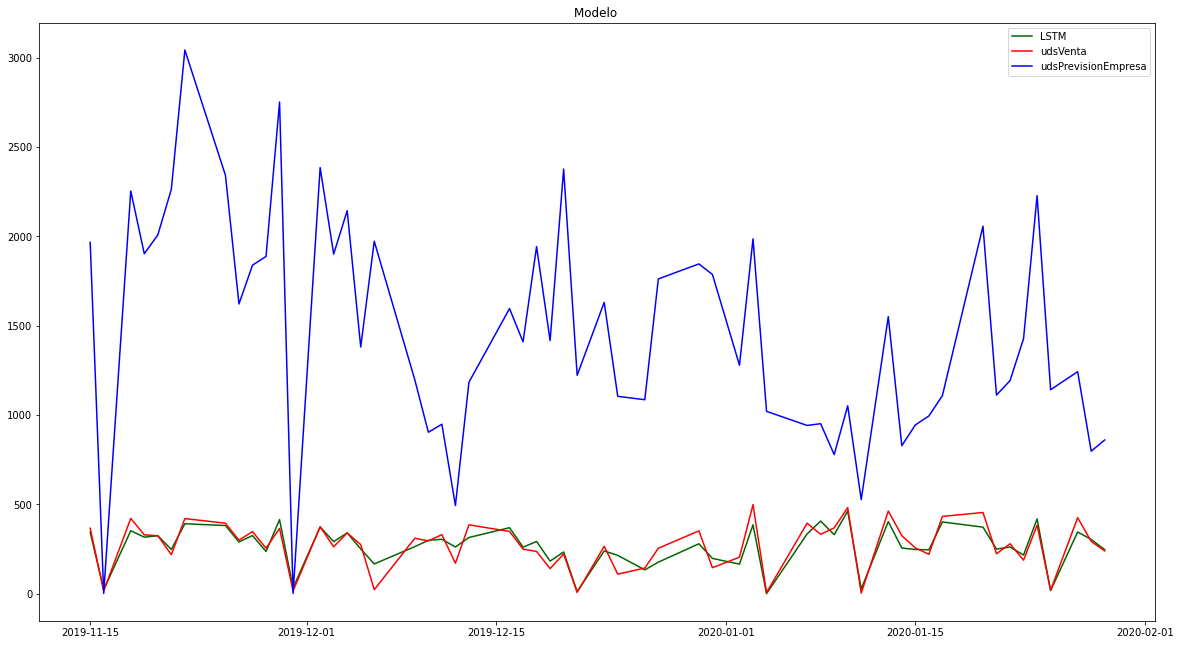

In [ ]:
# Plot
plt.rcParams["figure.figsize"] = (20,11)

plt.plot(x['predictions_LSTM'].loc[x["producto"]==87], color='darkgreen', label='LSTM')
plt.plot(x['udsVenta'].loc[x["producto"]==87], color='red', label='udsVenta')
plt.plot(x['udsPrevisionEmpresa'].loc[x["producto"]==87], color='blue', label='udsPrevisionEmpresa')




plt.title("Modelo ")
plt.legend()
plt.show()

### Conclusion del modelo:

La red LSTM se adapta a toda la variabilidad de la serie temporal debiod a que  LSTM es una gran herramienta para cualquier problema que tenga una secuencia.  En este caso a ser una secuencia semanal y con variables Exógenas y Endogenas de las que aprende el modelo, en varios productos obtenemos una previsión muy acertada para unos datos que el modelo no había ni visto.

Esto se observa en el la figura inferior para el producto 2

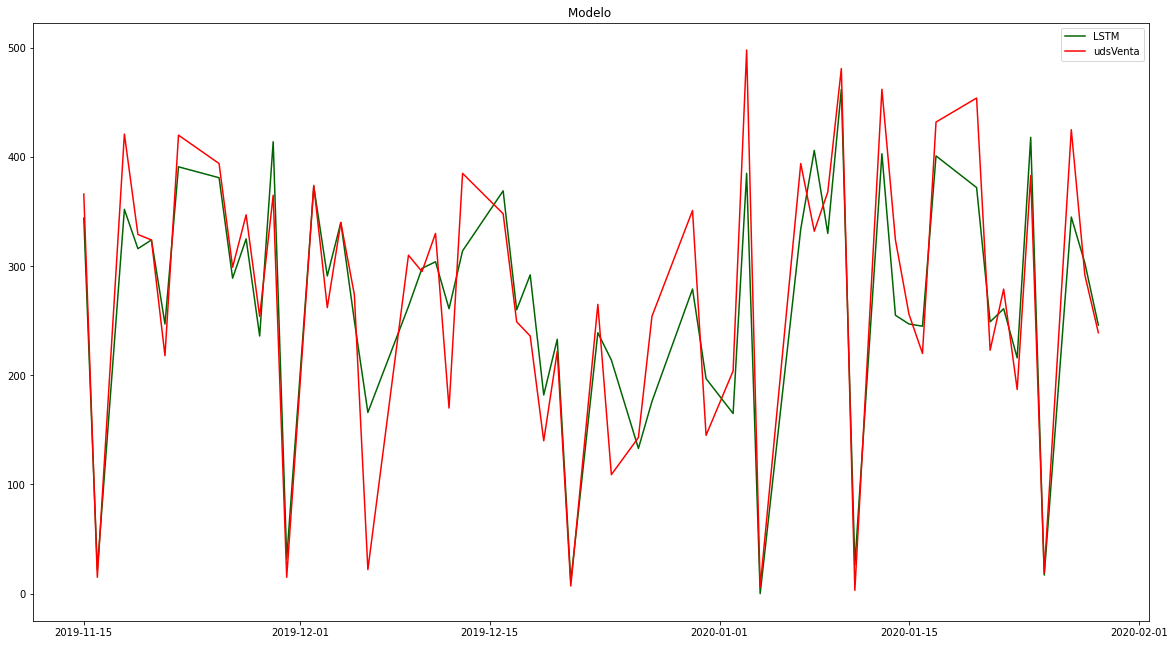

In [ ]:
# Plot
plt.rcParams["figure.figsize"] = (20,11)

plt.plot(x['predictions_LSTM'].loc[x["producto"]==87], color='darkgreen', label='LSTM')
plt.plot(x['udsVenta'].loc[x["producto"]==87], color='red', label='udsVenta')




plt.title("Modelo ")
plt.legend()
plt.show()

Estimamos las unidades en stock para la previsión de la empresa y para la
previsión estimada con nuestro modelo:

Suponemos Leadtime de aprovisionamiento = 1 día
- Stock= stock de seguridad + previsión para ese día
- Stock de seguridad = Factor servicio *RMSE
- **RMSE = Root Mean Squared Error. Entiendo RMSE como la diferencia de las ventas con la previsión. Al ser un RMSE de solo dos datos no existe media ni sumatorio y la raiz cuadrada del cuadrado de la diferencia es la resta**

stock= prevision+1.64*RMSE

  Calculamos el Coste total = Coste stock + coste ventas perdidas
- Cuando el stock es más alto que la venta real, incurrimos en coste de stock.
- Cuando el stock es más bajo que la venta real, incurrimos en coste de stock + coste de
venta perdida.

In [ ]:
df_Costes_Modelo = pd.DataFrame(index=df_costes.index, data=np.zeros((df_costes.shape[0],)), columns= ['predictions'])


In [ ]:
df_Costes_Modelo["producto"]=df_costes[["producto"]]

In [ ]:
df_Costes_Modelo["fecha"]=df_costes[["fecha"]]

In [ ]:
df_Costes_Modelo

,predictions,producto,fecha
1600,0.0,1,2019-11-15
1601,0.0,1,2019-11-16
1603,0.0,1,2019-11-18
1604,0.0,1,2019-11-19
1605,0.0,1,2019-11-20
...,...,...,...
137303,0.0,98,2020-01-24
137304,0.0,98,2020-01-25
137306,0.0,98,2020-01-27
137307,0.0,98,2020-01-28


*Se hace el comparado con productos con id_producto inferior a 80*

In [ ]:
  for p in products_id: 
    print("Generando Costes para producto: {}".format(p))

    df1=df_costes.loc[df_costes["producto"]==p]
    df1["RMSE_diario"]= df1["predictions_LSTM"] - df1["udsVenta"]
    df1["Stock"]=df1["udsVenta"]+(1.64*df1["RMSE_diario"])
    df1["Coste_almacenaje"]=(df1["precio"]*0.05)*(df1["Stock"])
    df1["Rotura_Stock"]=0 
    df1.loc[df1["RMSE_diario"]<0,"Rotura_Stock"]=abs(df1["RMSE_diario"])
    df1["Coste_venta"]=df1["Rotura_Stock"]*0.15*df1["precio"]
    df1["Coste_Total"]=df1["Coste_venta"]+df1["Coste_almacenaje"]
    print(df1["Coste_Total"].sum())


    df1["RMSE_diario_empresa"]= df1["udsPrevisionEmpresa"] - df1["udsVenta"]
    df1["Stock_empresa"]=df1["udsVenta"]+(1.64*df1["RMSE_diario_empresa"])
    df1["Coste_almacenaje_empresa"]=(df1["precio"]*0.05)*(df1["Stock_empresa"])
    df1["Rotura_Stock_empresa"]=0 
    df1.loc[df1["RMSE_diario_empresa"]<0,"Rotura_Stock_empresa"]=abs(df1["RMSE_diario_empresa"])
    df1["Coste_venta_empresa"]=df1["Rotura_Stock_empresa"]*0.15*df1["precio"]
    df1["Coste_Total_empresa"]=df1["Coste_venta_empresa"]+df1["Coste_almacenaje_empresa"]
    print(df1["Coste_Total_empresa"].sum())

    df_Costes_Modelo.loc[df1.index, "CostesModelo"]=df1.loc[:,"Coste_Total"]
    df_Costes_Modelo.loc[df1.index, "CostesEmpresa"]=df1.loc[:,"Coste_Total_empresa"] 


Generando Costes para producto: 1
45919.69956420001
219662.76442219998
Generando Costes para producto: 2
28522.783892879997
157733.4891708
Generando Costes para producto: 3
24435.5222826
133673.97012749998
Generando Costes para producto: 4
45182.30553720001
259392.42025632007
Generando Costes para producto: 5
15885.615672000002
102483.04744800001
Generando Costes para producto: 9
25866.874870720003
99460.96441216
Generando Costes para producto: 10
18585.585642000002
87274.22613000001
Generando Costes para producto: 11
21075.66165872
110090.20209236002
Generando Costes para producto: 12
11407.409496
76382.26270559999
Generando Costes para producto: 13
17915.4890856
104641.7750136
Generando Costes para producto: 14
16614.13061908
73236.45991325998
Generando Costes para producto: 15
5698.673753760002
20803.205058480005
Generando Costes para producto: 17
17810.581602200004
105265.02787499999
Generando Costes para producto: 18
21438.199993860002
92752.89982164
Generando Costes para producto

In [ ]:
df_Costes_Modelo.to_csv("/content/gdrive/MyDrive/TFM/3/costes_filtrado_25_05.csv", index = False)


In [ ]:
df_Costes_Modelo.shape

(3744, 5)

In [ ]:
df=pd.read_csv(ruta+"costes_filtrado_25_05.csv")


In [ ]:
df = df.drop(["predictions"], axis = 1)


In [ ]:
df['CostesModelo'] = df['CostesModelo'].apply(np.ceil)

In [ ]:
df['CostesEmpresa'] = df['CostesEmpresa'].apply(np.ceil)

### Conclusiones de Costes

Una vez calculado la previsión de costes con la previsión de empresas frente al escenario propuesto de previsión con el modelo que más se aproxima, se observa en la visualización dinamica inferior como mejora el coste.

Se  gráfica la estimación de costes para cada día y por producto en una gráfica viendo la evolución por escenario, en un gráfico dinámico

Por último se calcula en una tabla el Coste Total por escenario y día. Viendo como nuestra solución mejora por mayoría la previsión actual de la empresa.


In [ ]:
from plotly import tools
from plotly.tools import FigureFactory as FF
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
warnings.filterwarnings("ignore")
import plotly.express as px
init_notebook_mode()
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Output hidden; open in https://colab.research.google.com to view.

In [ ]:



df_long=pd.melt(df.sort_values(['fecha','producto']), id_vars=['fecha',"producto"], value_vars=df.columns[2:4])


lines_chart = px.line(df_long.sort_values(['fecha','producto']),
                      x='fecha', 
                      y='value',
                      color='variable',
                      text = "value",
                      color_discrete_sequence=['navy','royalblue'],
                      animation_frame = 'producto')
fig = go.Figure(lines_chart, layout_yaxis_range=[0,5000])
fig.update_layout(title_text="<b>Costes Por Producto",
                  xaxis_title="Fecha",
                  yaxis_title="Costes",)
fig.update_traces(textposition='top center', textfont_size=11)  
fig.update_layout(height = 500)
fig.show(renderer="colab")


In [ ]:

df_long=pd.melt(df.sort_values(['fecha','producto']), id_vars=['fecha',"producto"], value_vars=df.columns[2:4])


lines_chart = px.line(df_long.sort_values(['fecha','producto']),
                      x='fecha', 
                      y='value',
                      color='variable',
                      text = "value",
                      color_discrete_sequence=['navy','royalblue'],
                      animation_frame = 'producto')
fig = go.Figure(lines_chart, layout_yaxis_range=[0,1000])
fig.update_layout(title_text="<b>Costes Por Producto",
                  xaxis_title="Fecha",
                  yaxis_title="Costes",)
fig.update_traces(textposition='top center', textfont_size=11)  
fig.update_layout(height = 400)
fig.show()

In [ ]:
costes_totales=df.groupby(['fecha'], as_index=False)[["CostesModelo",'CostesEmpresa']].sum()

In [ ]:
pd.set_option('display.max_rows', 65)

In [ ]:
costes_totales["Reduccion_Costes"]=(((costes_totales["CostesModelo"]/costes_totales["CostesEmpresa"])-1)*100).apply(np.ceil)

In [ ]:
costes_totales

,fecha,CostesModelo,CostesEmpresa,Reduccion_Costes
0,2019-11-15,14355.0,78980.0,-81.0
1,2019-11-16,6282.0,36852.0,-82.0
2,2019-11-18,9790.0,72604.0,-86.0
3,2019-11-19,9651.0,69552.0,-86.0
4,2019-11-20,9001.0,89113.0,-89.0
5,2019-11-21,10886.0,107529.0,-89.0
6,2019-11-22,16246.0,131388.0,-87.0
7,2019-11-23,5777.0,45879.0,-87.0
8,2019-11-25,11447.0,72760.0,-84.0
9,2019-11-26,8501.0,56249.0,-84.0


### Reducción de Costes:
En este modelo se génera una mejoría también de costes pero da la sensación que en un escenario habitual la red LSTM se adapta mejor a la estacionalidad de las ventas

# 12 Mejoras en Futuro

- Profundizar en Redes Recurrentes.
- Buscar hiperparametros para Redes Recurrentes.
- Mejora del Stacking 2 para que pueda competir contra LSTM
- Crear Modelo para esenarios Adversos
- Modelo por categorías

In [ ]:
df_predictions.head()

,predictions,producto,predictions_XGB,predictions_XG2,predictions_STCK2,predictions_LSTM
1600,0.0,1,2129.0,724.0,1410.0,1122.0
1601,0.0,1,1771.0,646.0,320.0,0.0
1603,0.0,1,3925.0,3383.0,3361.0,4794.0
1604,0.0,1,1989.0,1050.0,1355.0,1585.0
1605,0.0,1,2974.0,1875.0,2640.0,1320.0


In [ ]:
df_predictions.drop_duplicates(inplace=True)

In [ ]:
ventas=pd.read_csv(ruta+"MODELAR_FINAL.csv")


In [ ]:
ventas=ventas.loc[(ventas["fecha"]>=FechaB)&(ventas["fecha"]<FechaFin)]

In [ ]:
ventas=ventas.loc[~ventas["producto"].isin([80, 81,83,92,93,99])]

In [ ]:
ventas=ventas.loc[ventas["udsVenta"]!=0]

In [ ]:
 ventas["fecha"]=pd.to_datetime(ventas['fecha'])

In [ ]:
ventas=ventas[ventas['weekday_Sunday']!= 1]

In [ ]:
ventas=ventas[["fecha","producto","udsVenta"]]

In [ ]:
ventas.tail()

,fecha,producto,udsVenta
137303,2020-01-24,98,269.0
137304,2020-01-25,98,7.0
137306,2020-01-27,98,190.0
137307,2020-01-28,98,210.0
137308,2020-01-29,98,223.0


In [ ]:
df_predictions.tail()

,predictions,producto,predictions_XGB,predictions_XG2,predictions_STCK2,predictions_LSTM
137303,0.0,98,243.0,224.0,233.0,274.0
137304,0.0,98,12.0,2.0,12.0,0.0
137306,0.0,98,253.0,260.0,257.0,230.0
137307,0.0,98,232.0,239.0,209.0,213.0
137308,0.0,98,233.0,231.0,221.0,228.0


In [ ]:
df_fin=pd.merge(ventas[["fecha","udsVenta"]], df_predictions, left_index=True, right_index=True)

In [ ]:
df_fin.columns

Index(['fecha', 'udsVenta', 'predictions', 'producto', 'predictions_XGB',
       'predictions_XG2', 'predictions_STCK2', 'predictions_LSTM'],
      dtype='object')

In [ ]:
from plotly import tools
from plotly.tools import FigureFactory as FF
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
warnings.filterwarnings("ignore")
import plotly.express as px
init_notebook_mode()
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_fin=df_fin[['fecha', 'producto', 'udsVenta', 
       'predictions_XGB', 'predictions_XG2','predictions_STCK2', 'predictions_LSTM']]

In [ ]:
df_fin.head(5)

,fecha,producto,udsVenta,predictions_XGB,predictions_XG2,predictions_STCK2,predictions_LSTM
1600,2019-11-15,1,2177.0,2129.0,724.0,1410.0,1122.0
1601,2019-11-16,1,311.0,1771.0,646.0,320.0,0.0
1603,2019-11-18,1,4044.0,3925.0,3383.0,3361.0,4794.0
1604,2019-11-19,1,1244.0,1989.0,1050.0,1355.0,1585.0
1605,2019-11-20,1,1555.0,2974.0,1875.0,2640.0,1320.0


In [ ]:
df_long=pd.melt(df_fin.sort_values(['fecha','producto']), id_vars=['fecha',"producto"], value_vars=df_fin.columns[2:8])


In [ ]:
df_long[["variable"]].drop_duplicates()

,variable
0,udsVenta
3742,predictions_XGB
7484,predictions_XG2
11226,predictions_STCK2
14968,predictions_LSTM


In [ ]:

lines_chart = px.line(df_long.sort_values(['fecha','producto']),
                      x='fecha', 
                      y='value',
                      color='variable',
                      text = "value",
                      color_discrete_sequence=['#0d0887', '#46039f', '#7201a8', '#9c179e', '#bd3786', '#d8576b'],
                      animation_frame = 'producto')
fig = go.Figure(lines_chart, layout_yaxis_range=[0,7000])
fig.update_layout(title_text="<b>Costes Por Producto",
                  xaxis_title="Fecha",
                  yaxis_title="Costes",)
fig.update_traces(textposition='top center', textfont_size=9)  
fig.update_layout(height = 600)
fig.show(renderer="colab")


# 13 Mejoras en Futuro

- Profundizar en Redes Recurrentes.
- Buscar hiperparametros para Redes Recurrentes.
- Mejora del Stacking 2 para que pueda competir contra LSTM
- Crear Modelo para esenarios Adversos
- Modelo por categorías

In [ ]:
costes[["fecha","producto"]].duplicated().sum()

0

In [ ]:
df_predictions.tail()

,predictions,producto,predictions_XGB,predictions_XG2,predictions_STCK2,predictions_LSTM
137303,0.0,98,243.0,224.0,233.0,274.0
137304,0.0,98,12.0,2.0,12.0,0.0
137306,0.0,98,253.0,260.0,257.0,230.0
137307,0.0,98,232.0,239.0,209.0,213.0
137308,0.0,98,233.0,231.0,221.0,228.0


In [ ]:
df_predictions.tail()

,predictions,producto,predictions_XGB,predictions_XG2,predictions_STCK2,predictions_LSTM
137303,0.0,98,243.0,224.0,233.0,274.0
137304,0.0,98,12.0,2.0,12.0,0.0
137306,0.0,98,253.0,260.0,257.0,230.0
137307,0.0,98,232.0,239.0,209.0,213.0
137308,0.0,98,233.0,231.0,221.0,228.0


In [ ]:
x=pd.merge(costes[["fecha","udsVenta","producto","precio","udsPrevisionEmpresa"]], df_predictions[["predictions_LSTM","predictions_XGB","predictions_XG2","predictions_STCK2"]], left_index=True, right_index=True)

In [ ]:
x["precio"].replace(0, 3.6140, inplace=True)


In [ ]:
df_costes=x

In [ ]:
df_costes.shape

(3742, 9)

In [ ]:
df_costes.index.duplicated().sum()

0

In [ ]:
#Usar el indice normal

#df_costes.index=df_costes["fecha"]

In [ ]:
df_costes.tail()

,fecha,udsVenta,producto,precio,udsPrevisionEmpresa,predictions_LSTM,predictions_XGB,predictions_XG2,predictions_STCK2
137303,2020-01-24,269.0,98,2.67050,1175.0,274.0,243.0,224.0,233.0
137304,2020-01-25,7.0,98,3.30399,60.0,0.0,12.0,2.0,12.0
137306,2020-01-27,190.0,98,3.30399,845.0,230.0,253.0,260.0,257.0
137307,2020-01-28,210.0,98,3.30399,907.0,213.0,232.0,239.0,209.0
137308,2020-01-29,223.0,98,3.30399,718.0,228.0,233.0,231.0,221.0


In [ ]:
df_Costes_Modelo = pd.DataFrame(index=df_costes.index, data=np.zeros((df_costes.shape[0],)), columns= ['predictions'])


In [ ]:
df_Costes_Modelo["producto"]=df_costes[["producto"]]

In [ ]:
df_Costes_Modelo["fecha"]=df_costes[["fecha"]]

In [ ]:
pd.set_option('display.max_rows', 65)

In [ ]:
df1.index.duplicated().sum()

0

In [ ]:

for p in products_id: 
    print("Generando Costes para producto: {}".format(p))

    df1=df_costes.loc[df_costes["producto"]==p]
    #df1.index=df1["fecha"]
    df1["RMSE_diario"]= df1["predictions_LSTM"]-df1["udsVenta"]
    df1["Stock"]=df1["udsVenta"]+(1.64*df1["RMSE_diario"])
    df1["Coste_almacenaje"]=(df1["precio"]*0.05)*(df1["Stock"])
    df1["Rotura_Stock"]=0 
    df1.loc[df1["RMSE_diario"]<0,"Rotura_Stock"]=abs(df1["RMSE_diario"])
    df1["Coste_venta"]=df1["Rotura_Stock"]*0.15*df1["precio"]
    df1["Coste_Total"]=df1["Coste_venta"]+df1["Coste_almacenaje"]
    print(df1["Coste_Total"].sum())

    df1["RMSE_diario_empresa"]= df1["udsPrevisionEmpresa"] - df1["udsVenta"]
    df1["Stock_empresa"]=df1["udsVenta"]+(1.64*df1["RMSE_diario_empresa"])
    df1["Coste_almacenaje_empresa"]=(df1["precio"]*0.05)*(df1["Stock_empresa"])
    df1["Rotura_Stock_empresa"]=0 
    df1.loc[df1["RMSE_diario_empresa"]<0,"Rotura_Stock_empresa"]=abs(df1["RMSE_diario_empresa"])
    df1["Coste_venta_empresa"]=df1["Rotura_Stock_empresa"]*0.15*df1["precio"]
    df1["Coste_Total_empresa"]=df1["Coste_venta_empresa"]+df1["Coste_almacenaje_empresa"]
    
    print(df1["Coste_Total_empresa"].sum())


    df1["RMSE_diario_XGB"]= df1["predictions_XGB"] - df1["udsVenta"]
    df1["Stock_XGB"]=df1["udsVenta"]+(1.64*df1["RMSE_diario_XGB"])
    df1["Coste_almacenaje_XGB"]=(df1["precio"]*0.05)*(df1["Stock_XGB"])
    df1["Rotura_Stock_XGB"]=0 
    df1.loc[df1["RMSE_diario_XGB"]<0,"Rotura_Stock_XGB"]=abs(df1["RMSE_diario_XGB"])
    df1["Coste_venta_XGB"]=df1["Rotura_Stock_XGB"]*0.15*df1["precio"]
    df1["Coste_Total_XGB"]=df1["Coste_venta_XGB"]+df1["Coste_almacenaje_XGB"]
    print(df1["Coste_Total_XGB"].sum())

    df1["RMSE_diario_STCK2"]= df1["predictions_STCK2"] - df1["udsVenta"]
    df1["Stock_STCK2"]=df1["udsVenta"]+(1.64*df1["RMSE_diario_STCK2"])
    df1["Coste_almacenaje_STCK2"]=(df1["precio"]*0.05)*(df1["Stock_STCK2"])
    df1["Rotura_Stock_STCK2"]=0 
    df1.loc[df1["RMSE_diario_STCK2"]<0,"Rotura_Stock_STCK2"]=abs(df1["RMSE_diario_STCK2"])
    df1["Coste_venta_STCK2"]=df1["Rotura_Stock_STCK2"]*0.15*df1["precio"]
    df1["Coste_Total_STCK2"]=df1["Coste_venta_STCK2"]+df1["Coste_almacenaje_STCK2"]
    print(df1["Coste_Total_STCK2"].sum())

    df1["RMSE_diario_XGB2"]= df1["predictions_XG2"] - df1["udsVenta"]
    df1["Stock_XGB2"]=df1["udsVenta"]+(1.64*df1["RMSE_diario_XGB2"])
    df1["Coste_almacenaje_XGB2"]=(df1["precio"]*0.05)*(df1["Stock_XGB2"])
    df1["Rotura_Stock_XGB2"]=0 
    df1.loc[df1["RMSE_diario_XGB2"]<0,"Rotura_Stock_XGB2"]=abs(df1["RMSE_diario_XGB2"])
    df1["Coste_venta_XGB2"]=df1["Rotura_Stock_XGB2"]*0.15*df1["precio"]
    df1["Coste_Total_XGB2"]=df1["Coste_venta_XGB2"]+df1["Coste_almacenaje_XGB2"]
    print(df1["Coste_Total_XGB2"].sum())

    df_Costes_Modelo.loc[df1.index, "CostesModelo"]=df1.loc[:,"Coste_Total"]
    df_Costes_Modelo.loc[df1.index, "CostesEmpresa"]=df1.loc[:,"Coste_Total_empresa"] 
    df_Costes_Modelo.loc[df1.index, "Coste_Total_XGB"]=df1.loc[:,"Coste_Total_XGB"] 
    df_Costes_Modelo.loc[df1.index, "Coste_Total_STCK2"]=df1.loc[:,"Coste_Total_STCK2"] 
    df_Costes_Modelo.loc[df1.index, "Coste_Total_XGB2"]=df1.loc[:,"Coste_Total_XGB2"] 



Generando Costes para producto: 1
45919.69956420001
219662.76442219998
57790.38607760001
52548.879273000006
55141.92513170001
Generando Costes para producto: 2
28522.783892879997
157733.4891708
28433.637930240002
27447.443891999996
32364.430722719997
Generando Costes para producto: 3
24435.5222826
133673.97012749998
25820.5404402
23947.785853200003
26656.525288800003
Generando Costes para producto: 4
45182.30553720001
259392.42025632007
46703.745707580005
45001.31878242001
57305.922687
Generando Costes para producto: 5
15885.615672000002
102483.04744800001
16314.858161999999
16187.806584
17617.00671
Generando Costes para producto: 9
25866.874870720003
99460.96441216
27769.51808384
28151.61483264
28639.751171199998
Generando Costes para producto: 10
18585.585642000002
87274.22613000001
19776.838614
19425.539406
20226.521952
Generando Costes para producto: 11
21075.66165872
110090.20209236002
22822.078836079996
22600.345482500004
22940.267160879997
Generando Costes para producto: 12
1140

In [ ]:
df_Costes_Modelo.loc[df_Costes_Modelo["producto"]==1].sum()

predictions               0.000000
producto                 59.000000
CostesModelo          45919.699564
CostesEmpresa        219662.764422
Coste_Total_XGB       57790.386078
Coste_Total_STCK2     52548.879273
Coste_Total_XGB2      55141.925132
dtype: float64

In [ ]:
df_Costes_Modelo = df_Costes_Modelo.drop(["predictions"], axis = 1)


In [ ]:
df_Costes_Modelo['CostesModelo'] = df_Costes_Modelo['CostesModelo'].apply(np.ceil)

In [ ]:
df_Costes_Modelo['CostesEmpresa'] = df_Costes_Modelo['CostesEmpresa'].apply(np.ceil)
df_Costes_Modelo['Coste_Total_XGB'] = df_Costes_Modelo['Coste_Total_XGB'].apply(np.ceil)
df_Costes_Modelo['Coste_Total_STCK2'] = df_Costes_Modelo['Coste_Total_STCK2'].apply(np.ceil)
df_Costes_Modelo['Coste_Total_XGB2'] = df_Costes_Modelo['Coste_Total_XGB2'].apply(np.ceil)

In [ ]:
df_Costes_Modelo.to_csv("/content/gdrive/MyDrive/TFM/3/costes_Total_filtrado.csv", index = False)


In [ ]:
df=pd.read_csv(ruta+"costes_Total_filtrado.csv")


In [ ]:
from plotly import tools
from plotly.tools import FigureFactory as FF
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
warnings.filterwarnings("ignore")
import plotly.express as px
init_notebook_mode()
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df.columns[2:7]

Index(['CostesModelo', 'CostesEmpresa', 'Coste_Total_XGB', 'Coste_Total_STCK2',
       'Coste_Total_XGB2'],
      dtype='object')

In [ ]:



df_long=pd.melt(df.sort_values(['fecha','producto']), id_vars=['fecha',"producto"], value_vars=df.columns[2:7])


lines_chart = px.line(df_long.sort_values(['fecha','producto']),
                      x='fecha', 
                      y='value',
                      color='variable',
                      text = "value",
                      color_discrete_sequence=['navy','royalblue','red','green','orange'],
                      animation_frame = 'producto')
fig = go.Figure(lines_chart, layout_yaxis_range=[0,7000])
fig.update_layout(title_text="<b>Costes Por Producto",
                  xaxis_title="Fecha",
                  yaxis_title="Costes",)
fig.update_traces(textposition='top center', textfont_size=11)  
fig.update_layout(height = 400)
fig.show(renderer="colab")


In [ ]:
costes_totales=df.groupby(['fecha'], as_index=False)[["CostesModelo",'CostesEmpresa','Coste_Total_XGB', 'Coste_Total_STCK2',
       'Coste_Total_XGB2']].sum()

In [ ]:
costes_totales["Reduccion_Costes_LSTM"]=(((costes_totales["CostesModelo"]/costes_totales["CostesEmpresa"])-1)*100).apply(np.ceil)
costes_totales["Reduccion_Costes_XGB"]=(((costes_totales["Coste_Total_XGB"]/costes_totales["CostesEmpresa"])-1)*100).apply(np.ceil)
costes_totales["Reduccion_Costes_STCK2"]=(((costes_totales["Coste_Total_STCK2"]/costes_totales["CostesEmpresa"])-1)*100).apply(np.ceil)
costes_totales["Reduccion_Costes_XGB2"]=(((costes_totales["Coste_Total_XGB2"]/costes_totales["CostesEmpresa"])-1)*100).apply(np.ceil)

In [ ]:
costes_totales.columns[6:10]

Index(['Reduccion_Costes_LSTM', 'Reduccion_Costes_XGB',
       'Reduccion_Costes_STCK2', 'Reduccion_Costes_XGB2'],
      dtype='object')

In [ ]:

df_long=pd.melt(costes_totales.sort_values(['fecha']), id_vars=['fecha'], value_vars=costes_totales.columns[6:10])


lines_chart = px.line(df_long.sort_values(['fecha']),
                      x='fecha', 
                      y='value',
                      color='variable',
                      text = "value",
                      color_discrete_sequence=['navy','royalblue','red','green'],
                      )
fig = go.Figure(lines_chart, layout_yaxis_range=[-100,0])
fig.update_layout(title_text="<b>Costes Por Producto",
                  xaxis_title="Fecha",
                  yaxis_title="Costes",)
fig.update_layout(height = 400)
fig.show(renderer="colab")
